In [1]:
import io
import os
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image
import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
HOME = os.environ.get("HOME_PATH")
VIDEO_PATH = os.path.join(HOME, "pipeline", "1. videos")
FRAME_PATH = os.path.join(HOME, "pipeline", "2. frames")
FRAME_DISTINCT_PATH = os.path.join(HOME, "pipeline", "2. frames_distinct")

In [10]:
file_names = list(glob.iglob(os.path.join(FRAME_DISTINCT_PATH, '**/*.png'), recursive=True))
test_image_path_static = file_names[0]
test_image_path_road = file_names[1]

In [11]:
def showarray(a, fmt='jpeg'):
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
def get_image(path):
    image = cv2.imread(path)
#     image = image.reshape((50, 100,3))
#     image = Image.open(path)
    return image

In [12]:
image_static =get_image(test_image_path_static)
image_road =get_image(test_image_path_road)

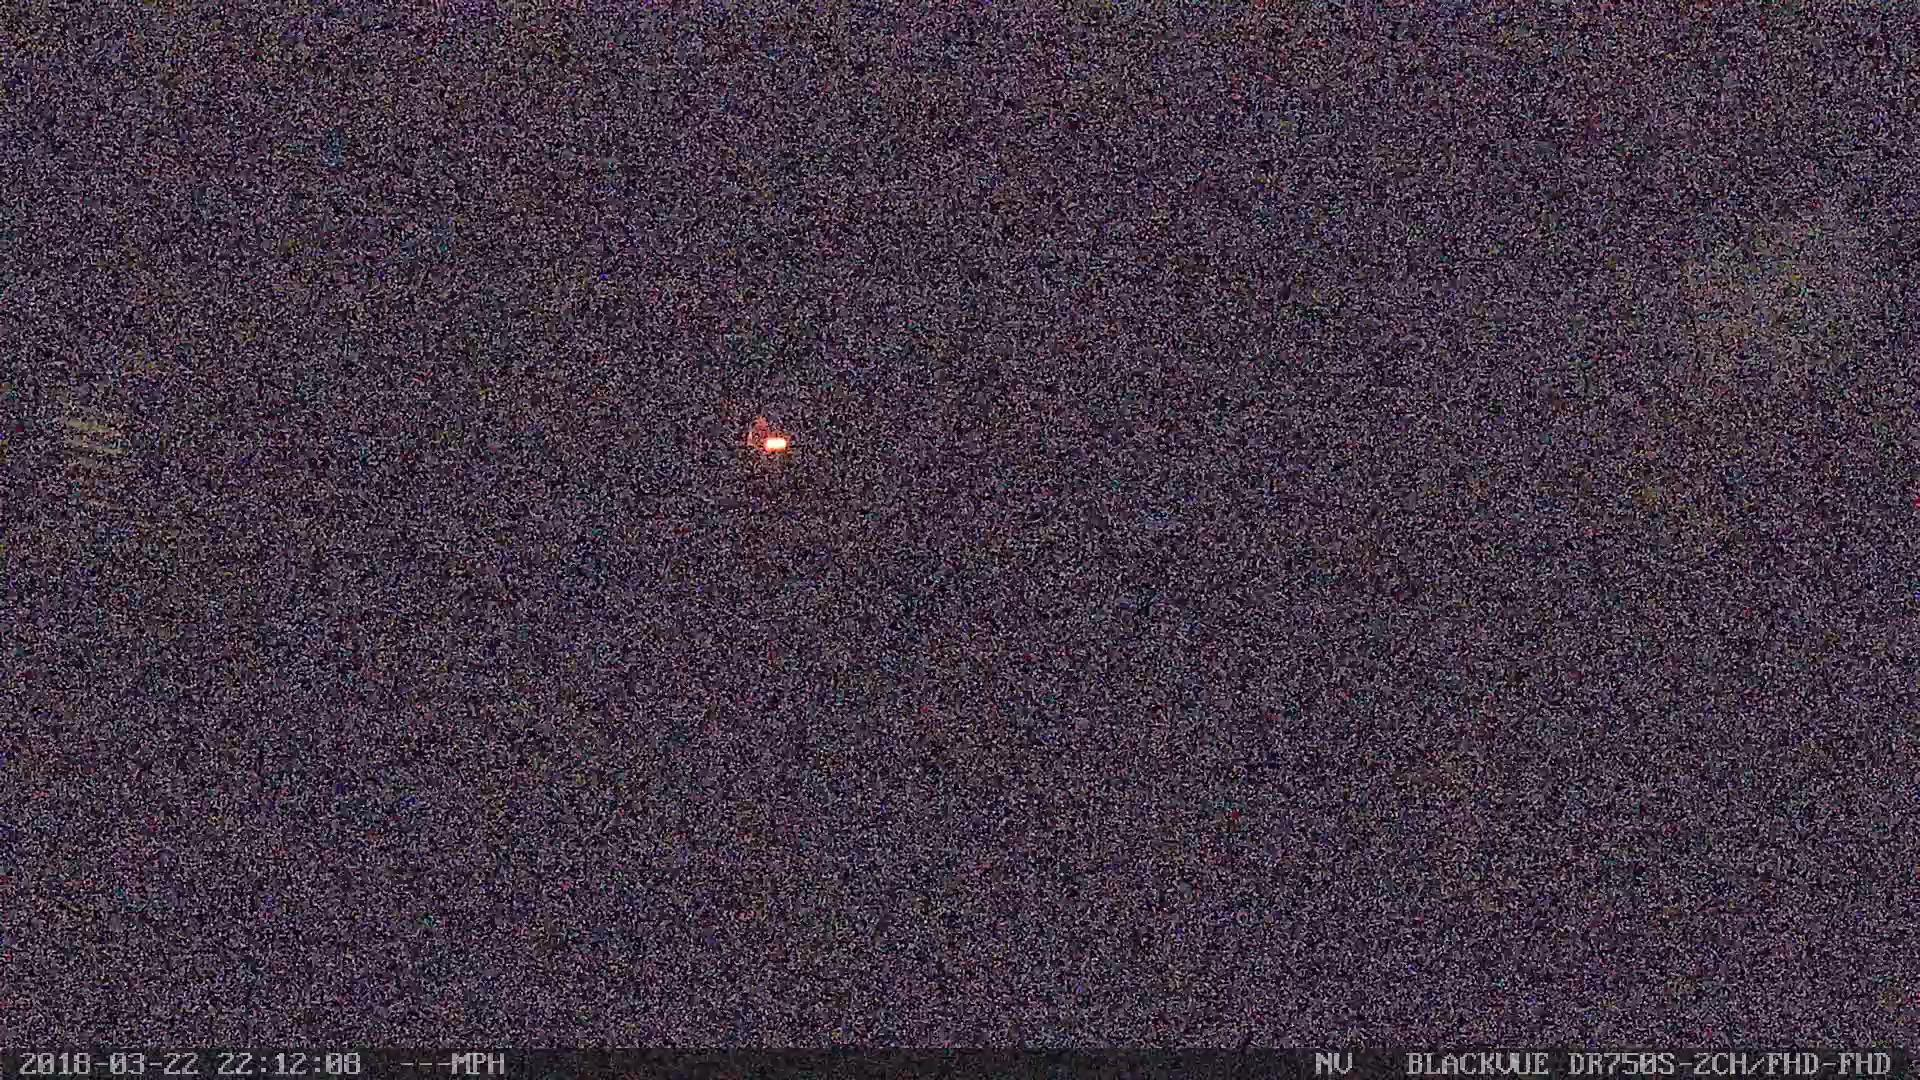

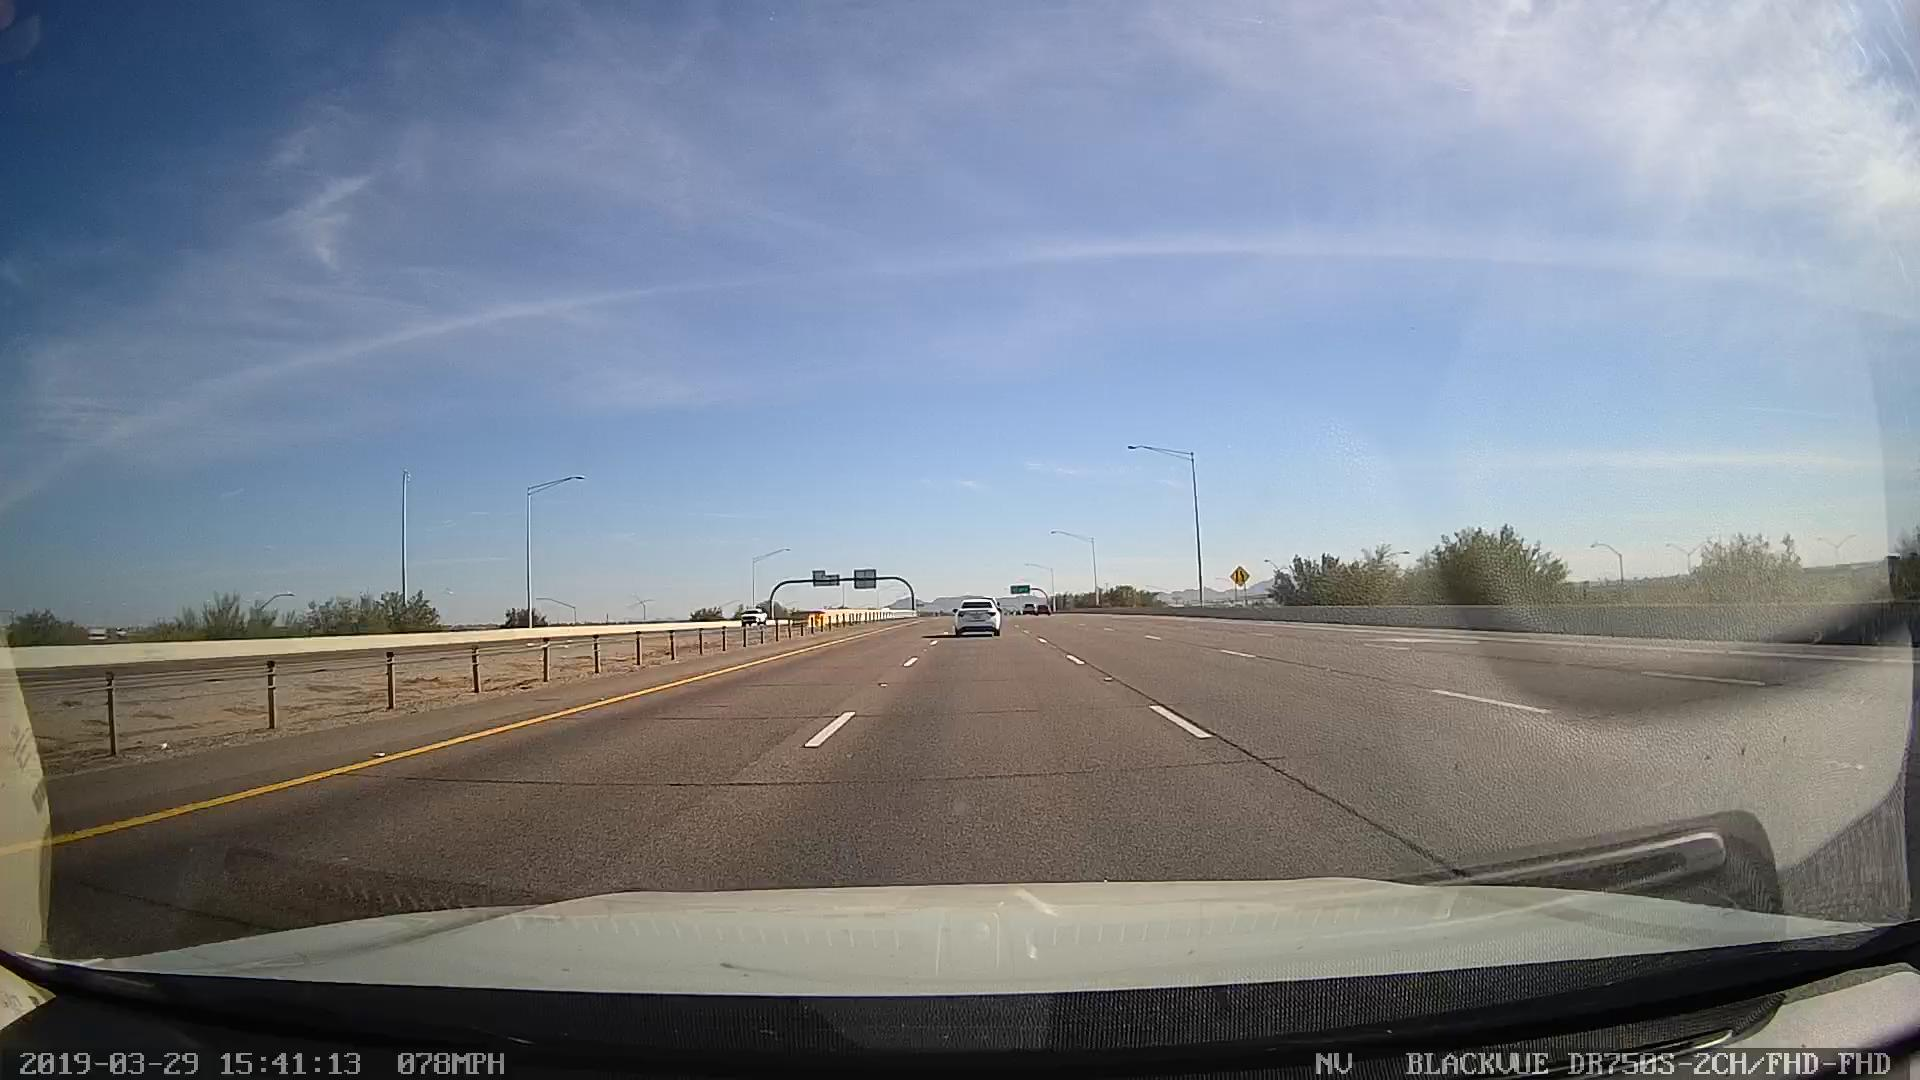

In [13]:
showarray(image_static)
showarray(image_road)

In [14]:
def show_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blured = cv2.medianBlur(gray,15)
#     blured = cv2.bilateralFilter(gray, 15, 150,150)
    edges = cv2.Canny(blured, 25,150)
    
    edges = cv2.bitwise_not(edges)
    showarray(blured)
    showarray(edges)

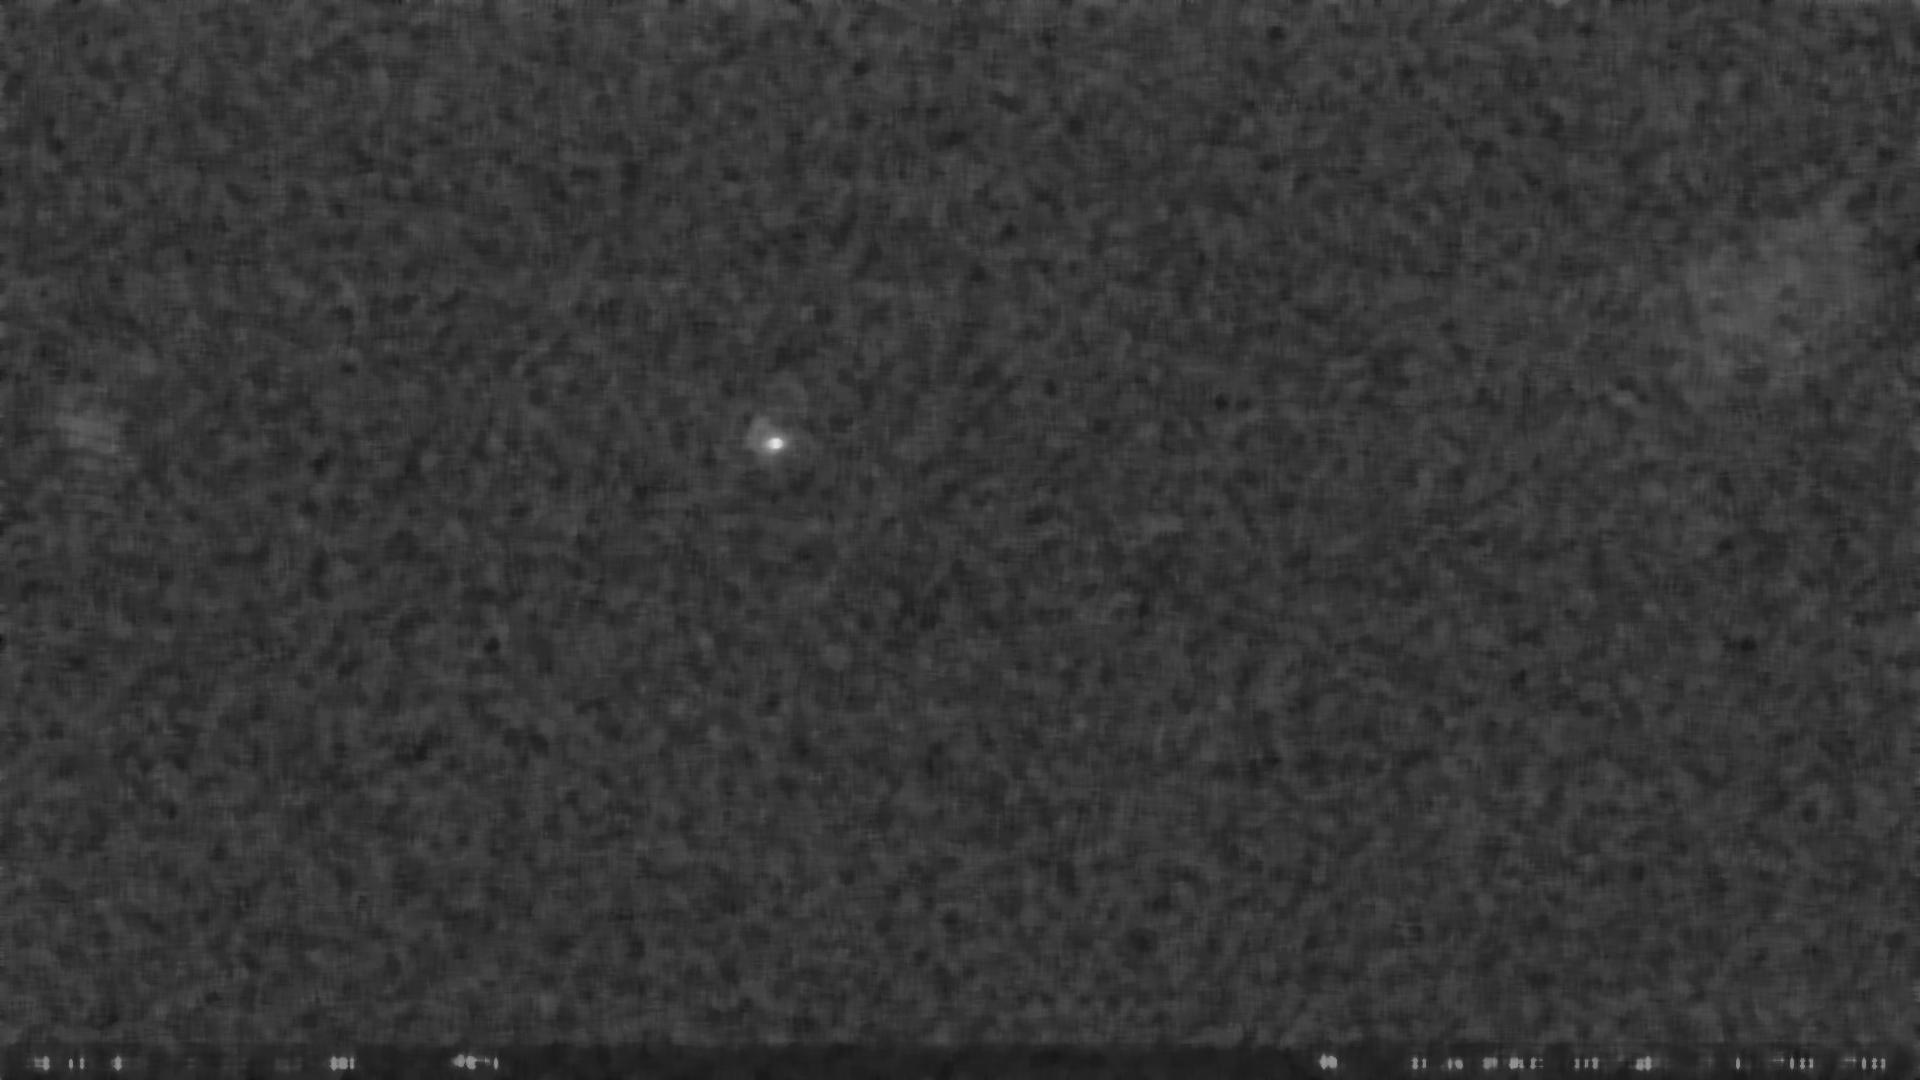

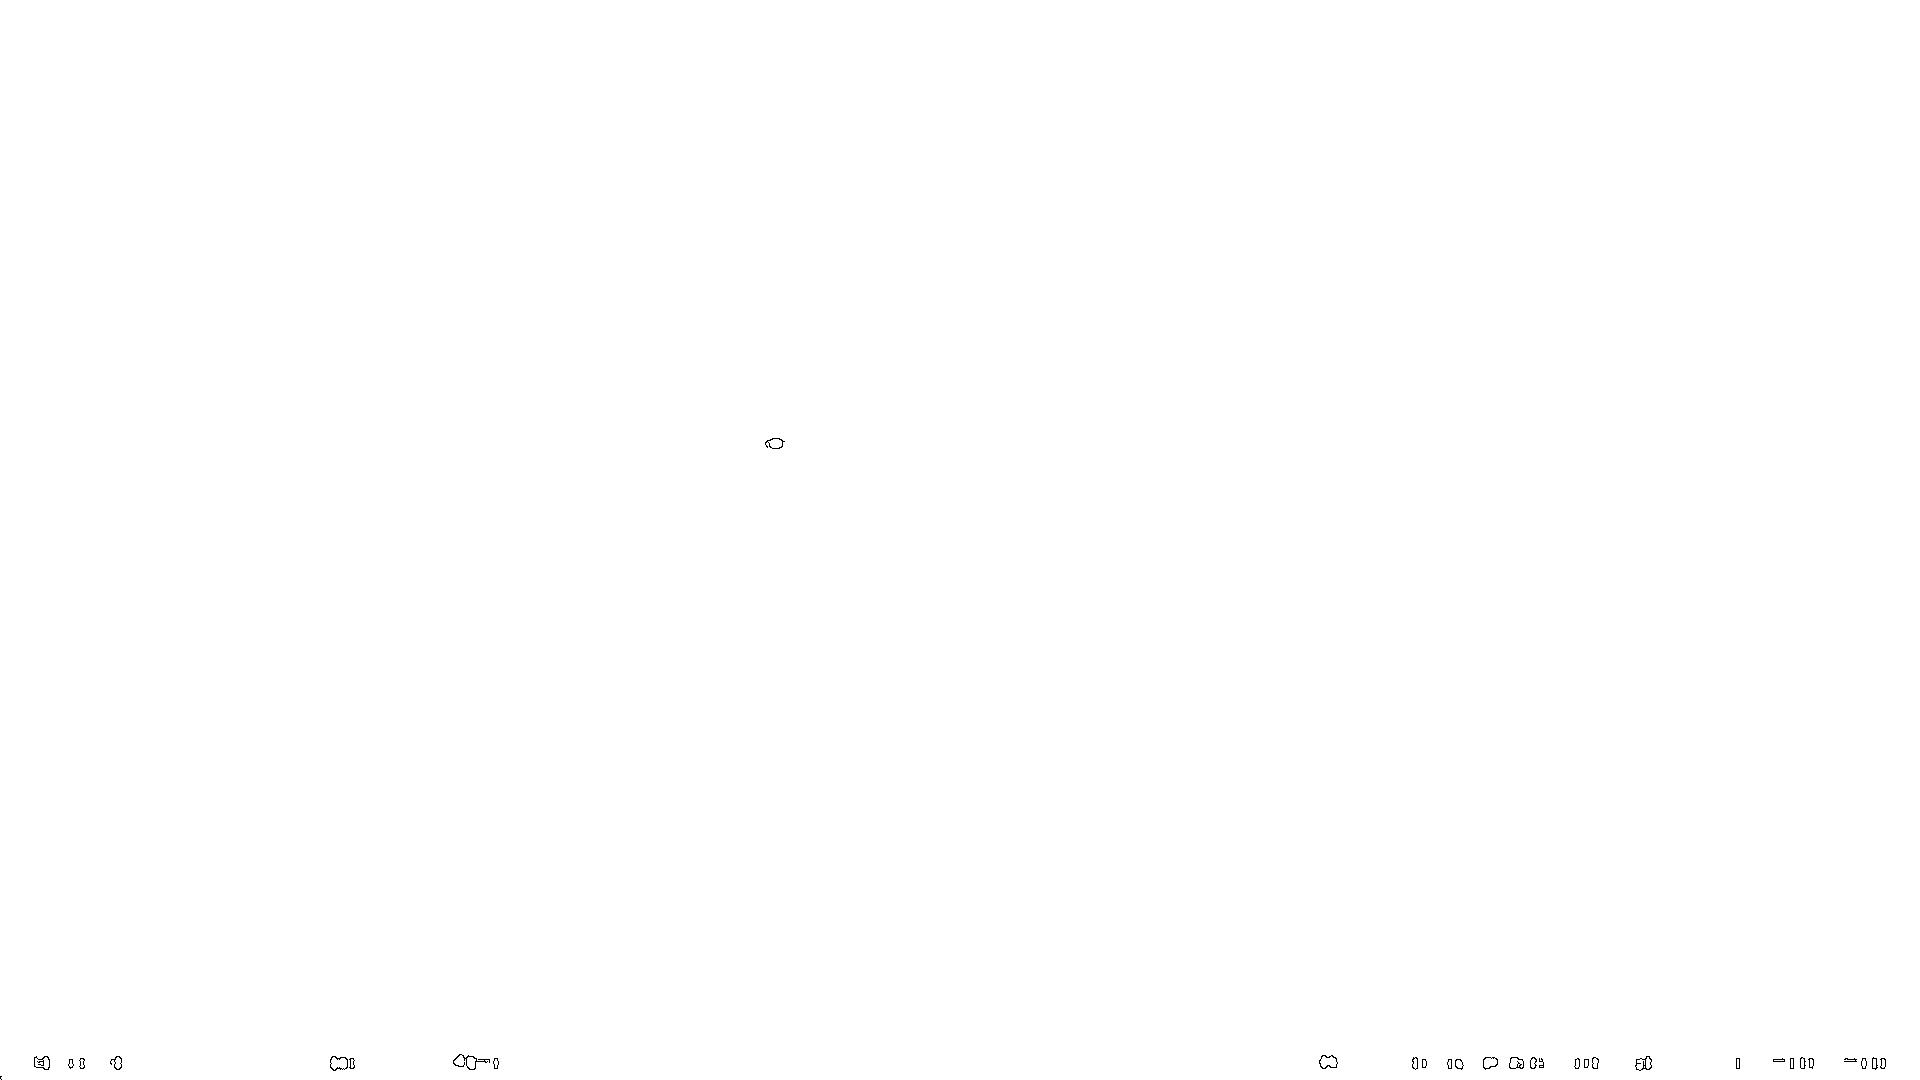

In [15]:
show_edges(image_static)


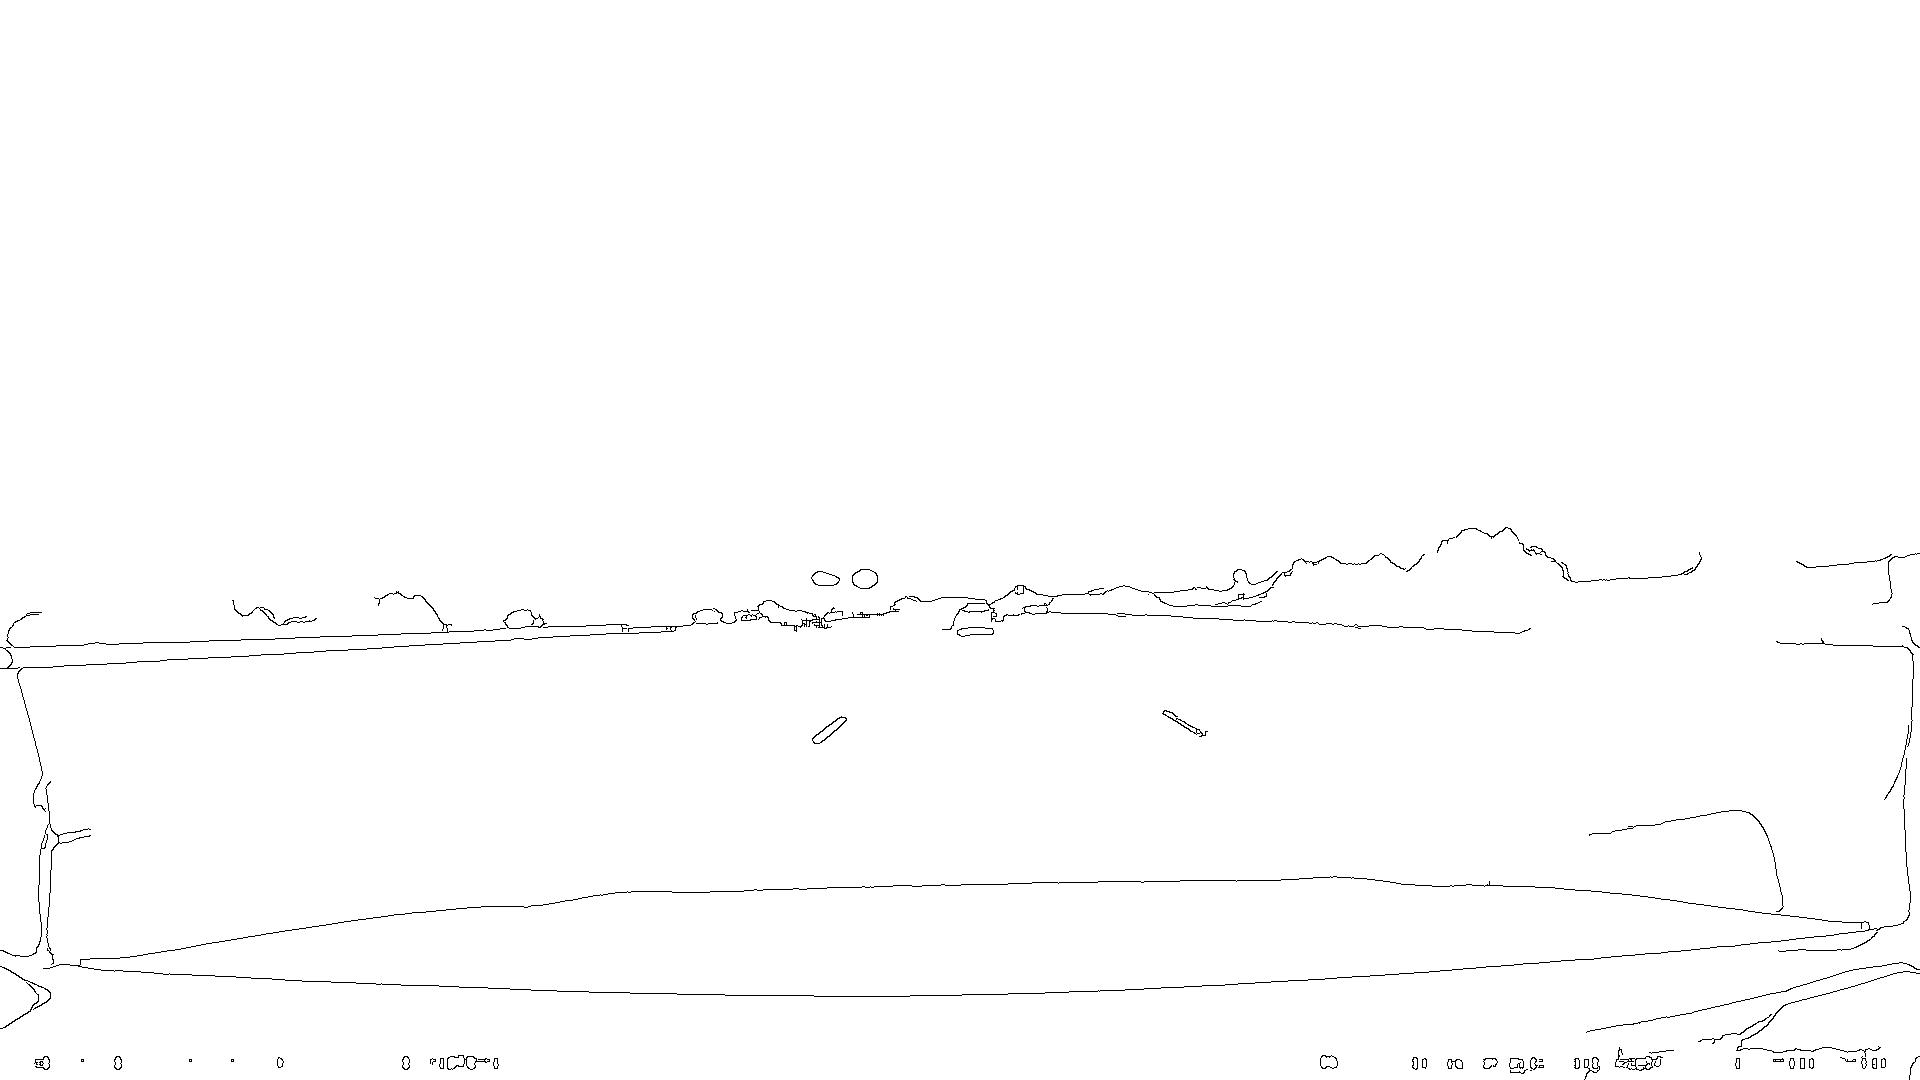

In [16]:
show_edges(image_road)

In [17]:
def show_edges_adaptive(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blured = cv2.medianBlur(gray,15)
    edges = cv2.adaptiveThreshold(blured, 255, cv2.THRESH_BINARY, cv2.THRESH_BINARY, 15, 8)
    showarray(edges)


In [18]:
show_edges_adaptive(image_static)

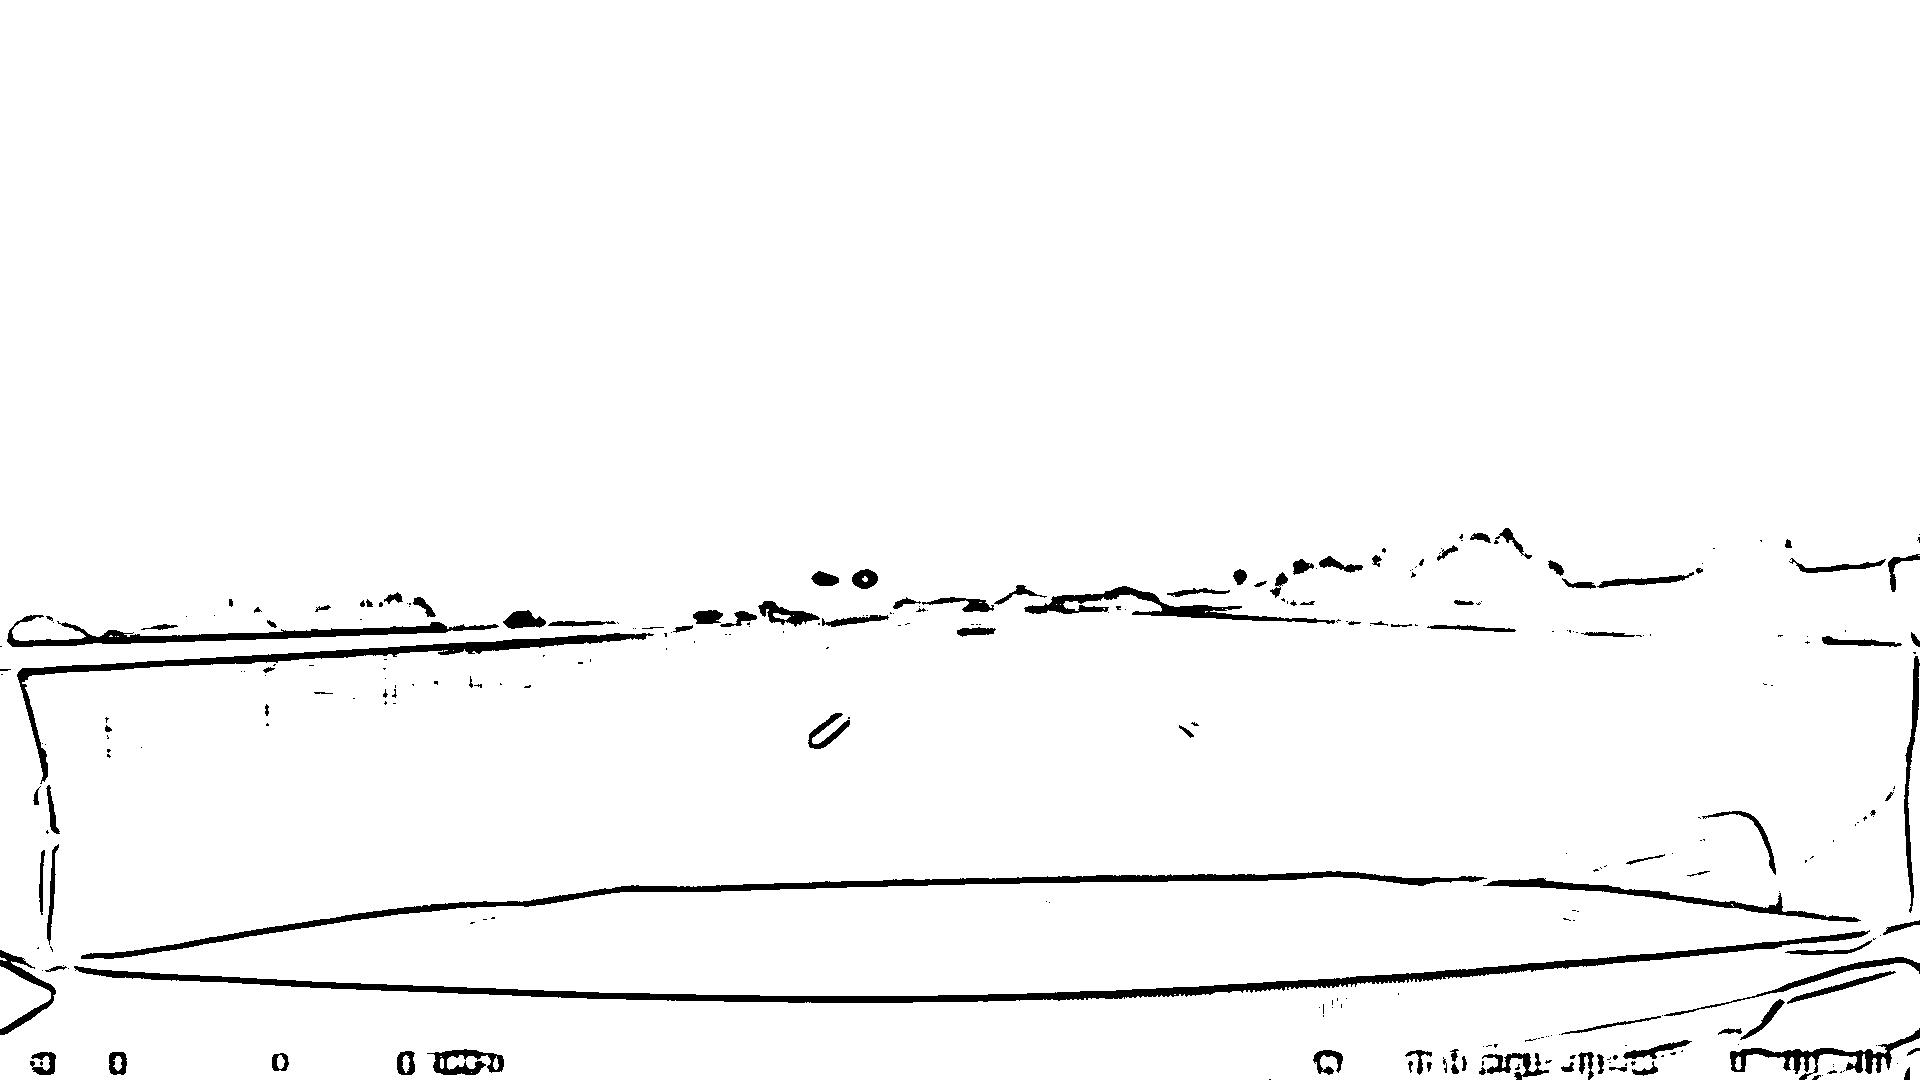

In [19]:
show_edges_adaptive(image_road)

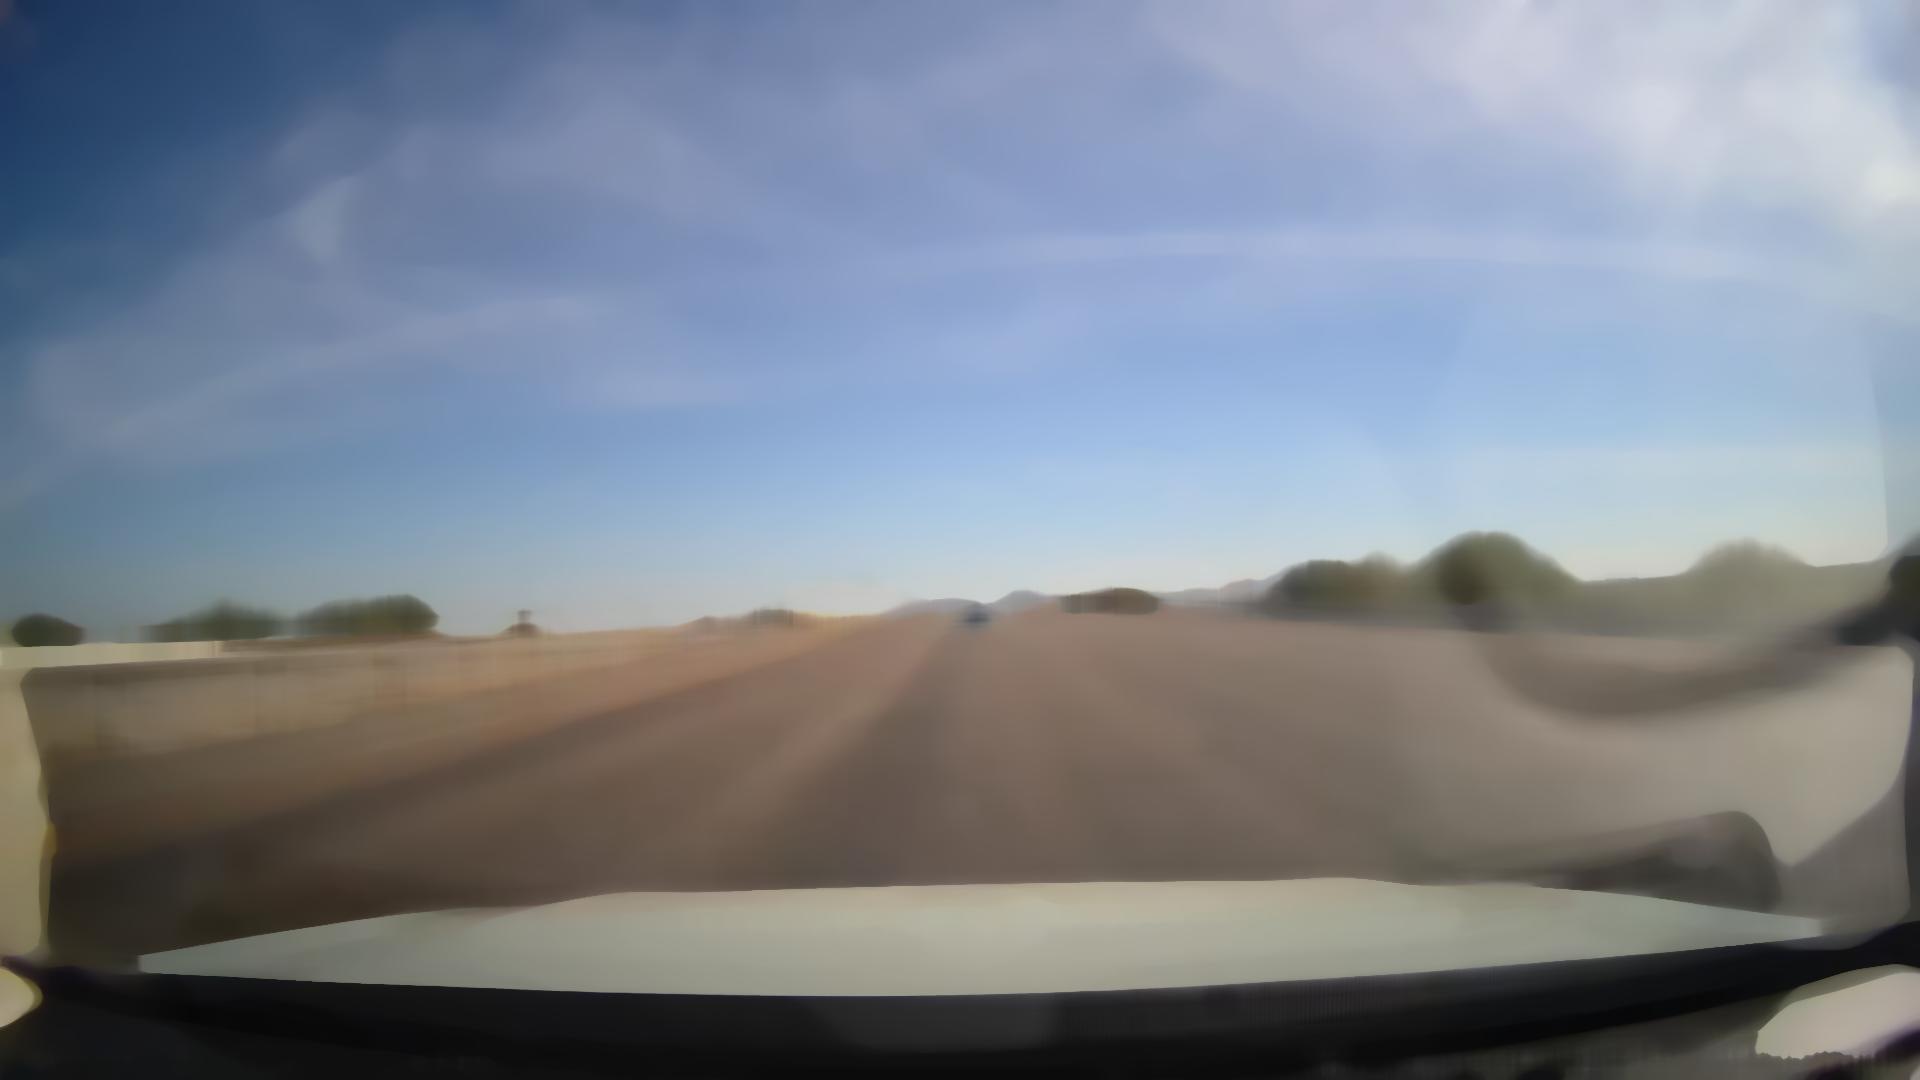

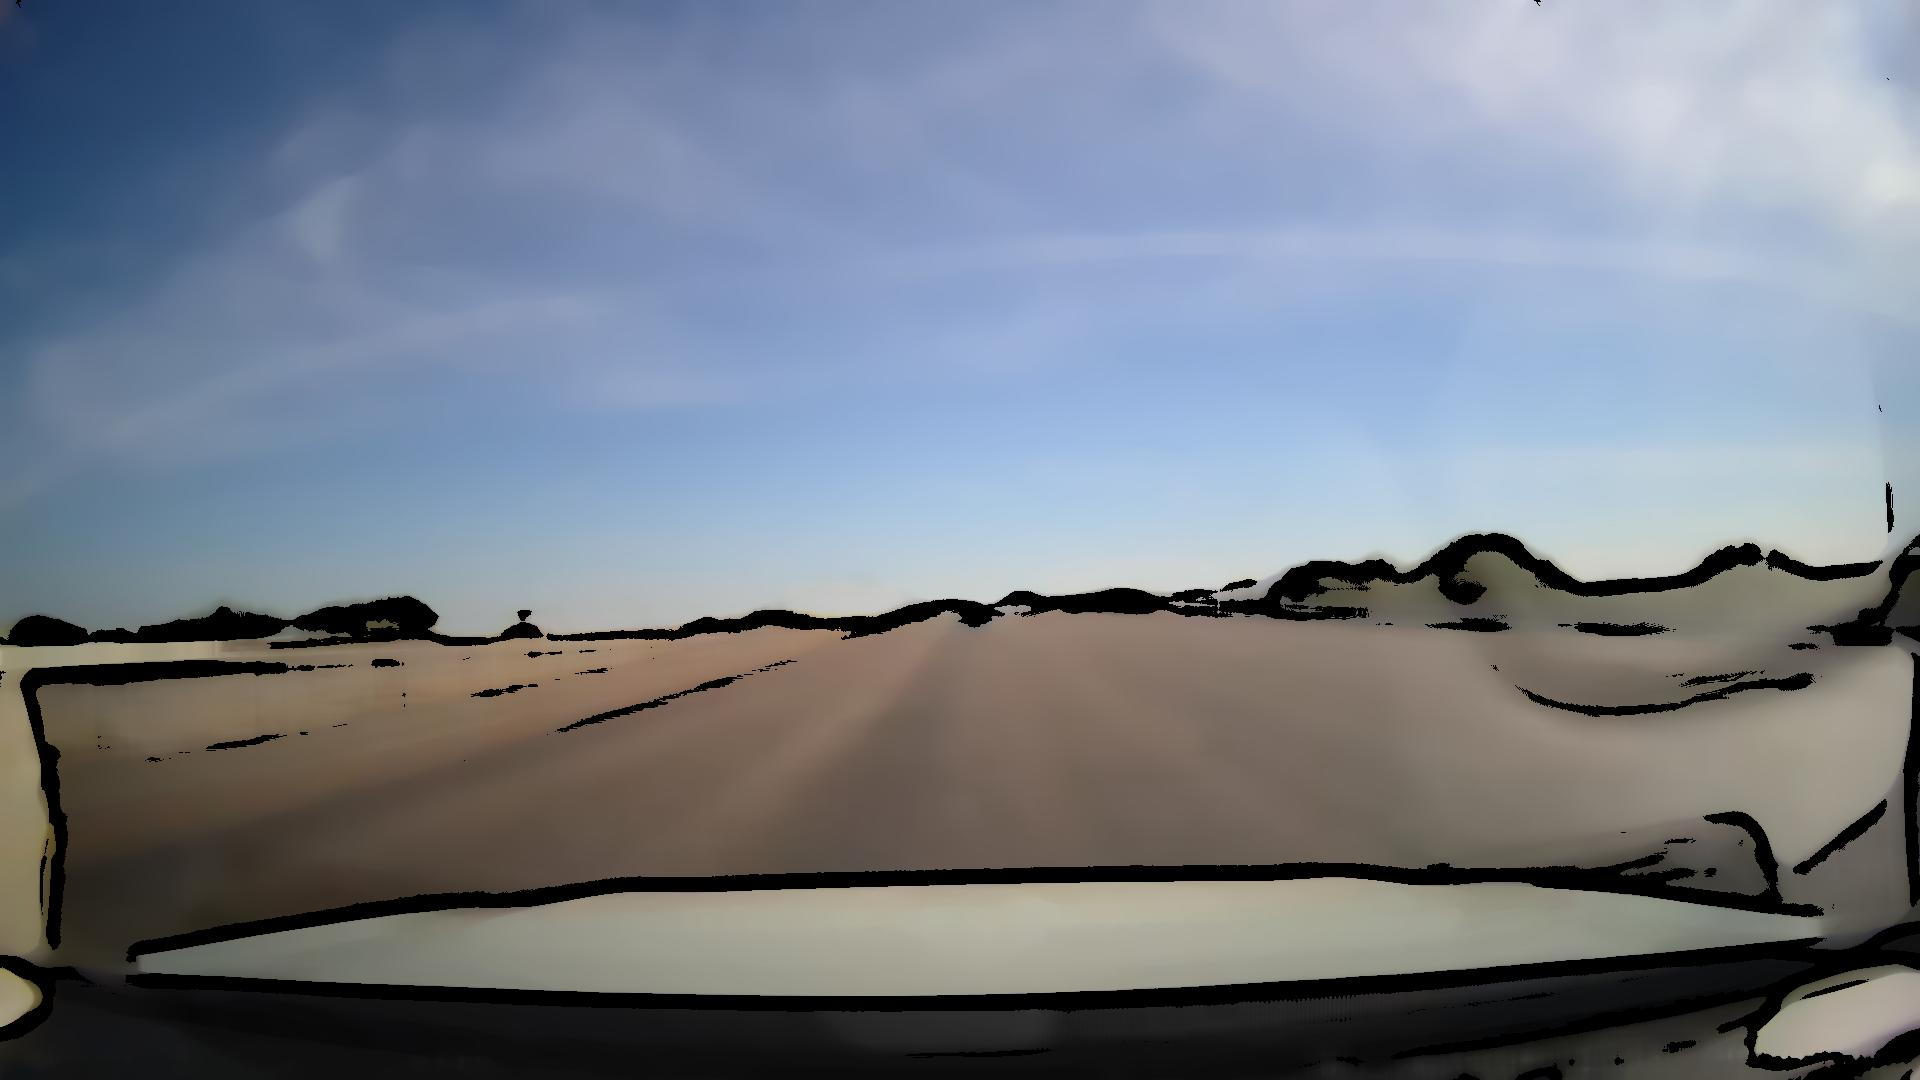

In [20]:
image = image_road

BLUR_RATE = 33
ALPHA = BLUR_RATE
BETA = 5

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blured = cv2.medianBlur(gray,BLUR_RATE)
#     blured = cv2.bilateralFilter(gray, 15, 150,150)
edges = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, ALPHA, BETA)
# edges = cv2.Canny(blured, ALPHA,BETA)
# edges = cv2.bitwise_not(edges)
color = cv2.medianBlur(image,BLUR_RATE)
cartoon = cv2.bitwise_and(color, color, mask=edges)
showarray(edges)
showarray(color)
showarray(cartoon)

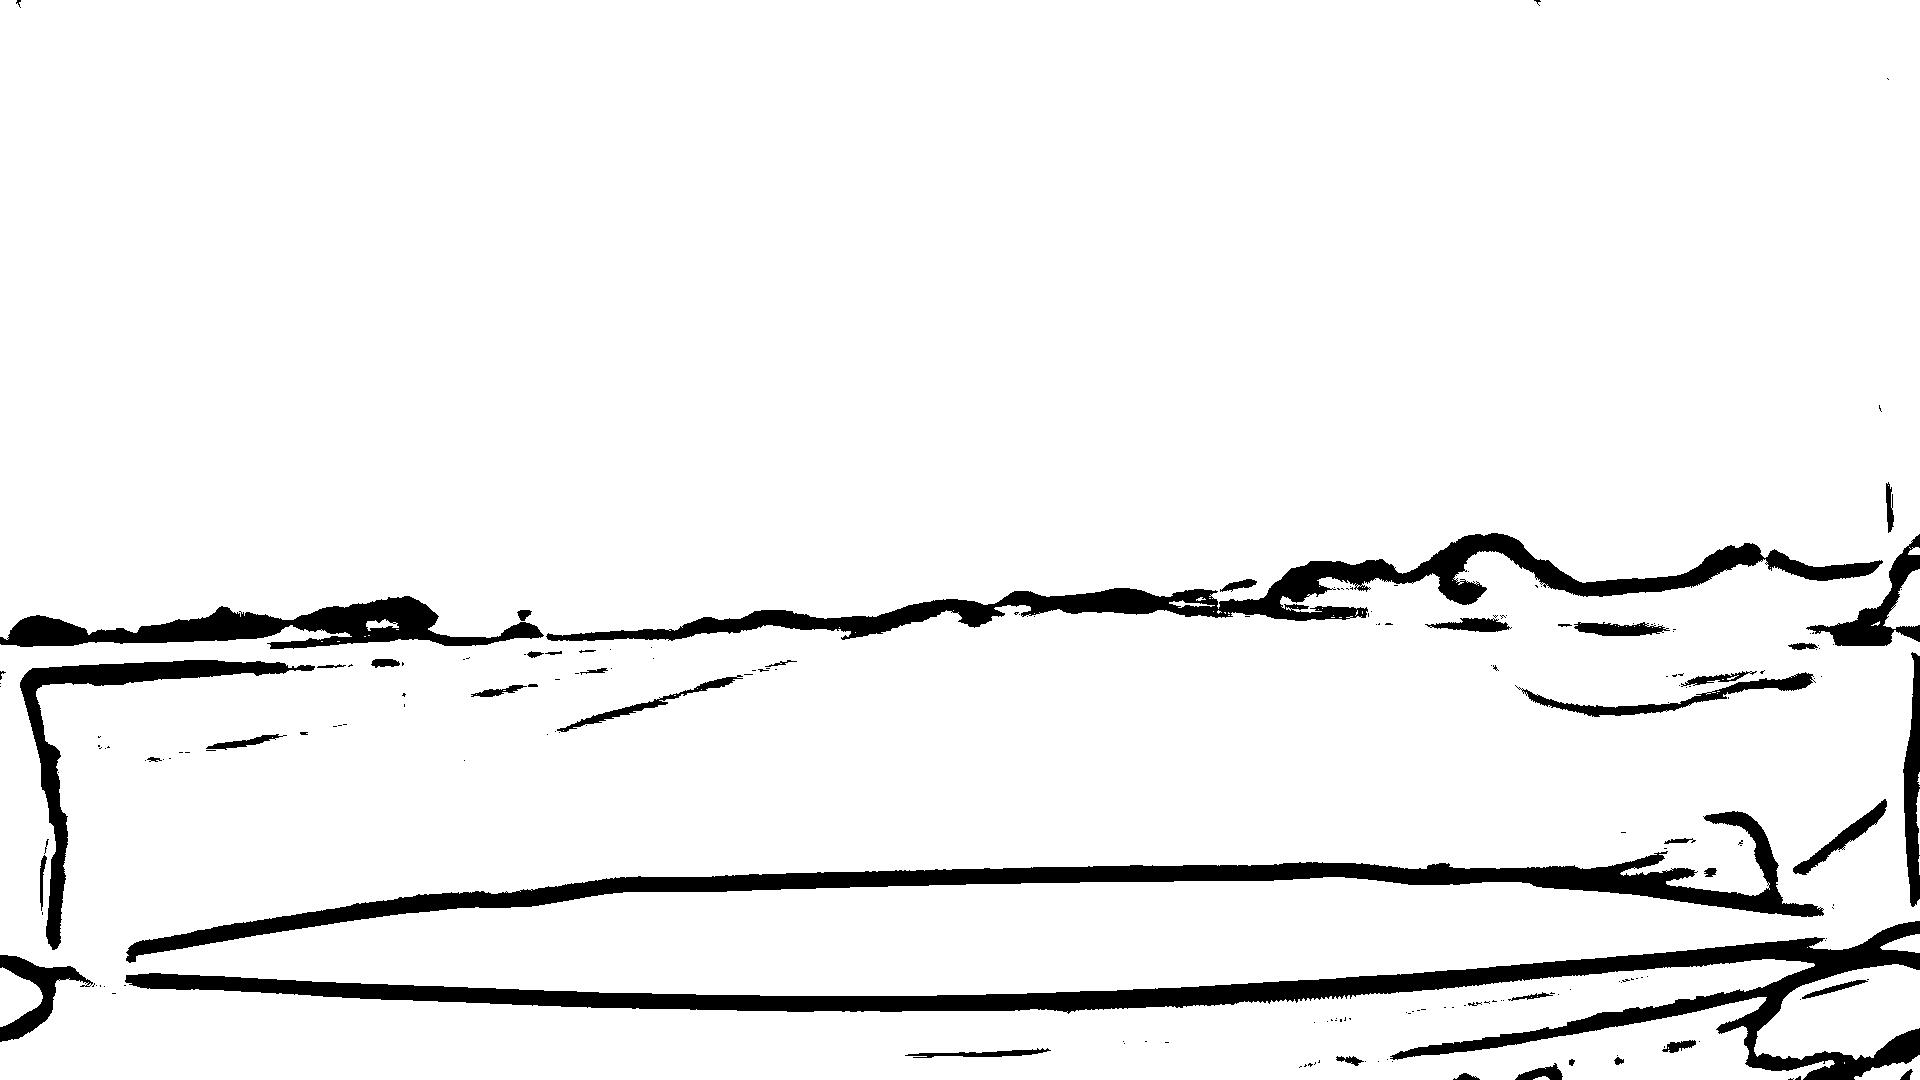

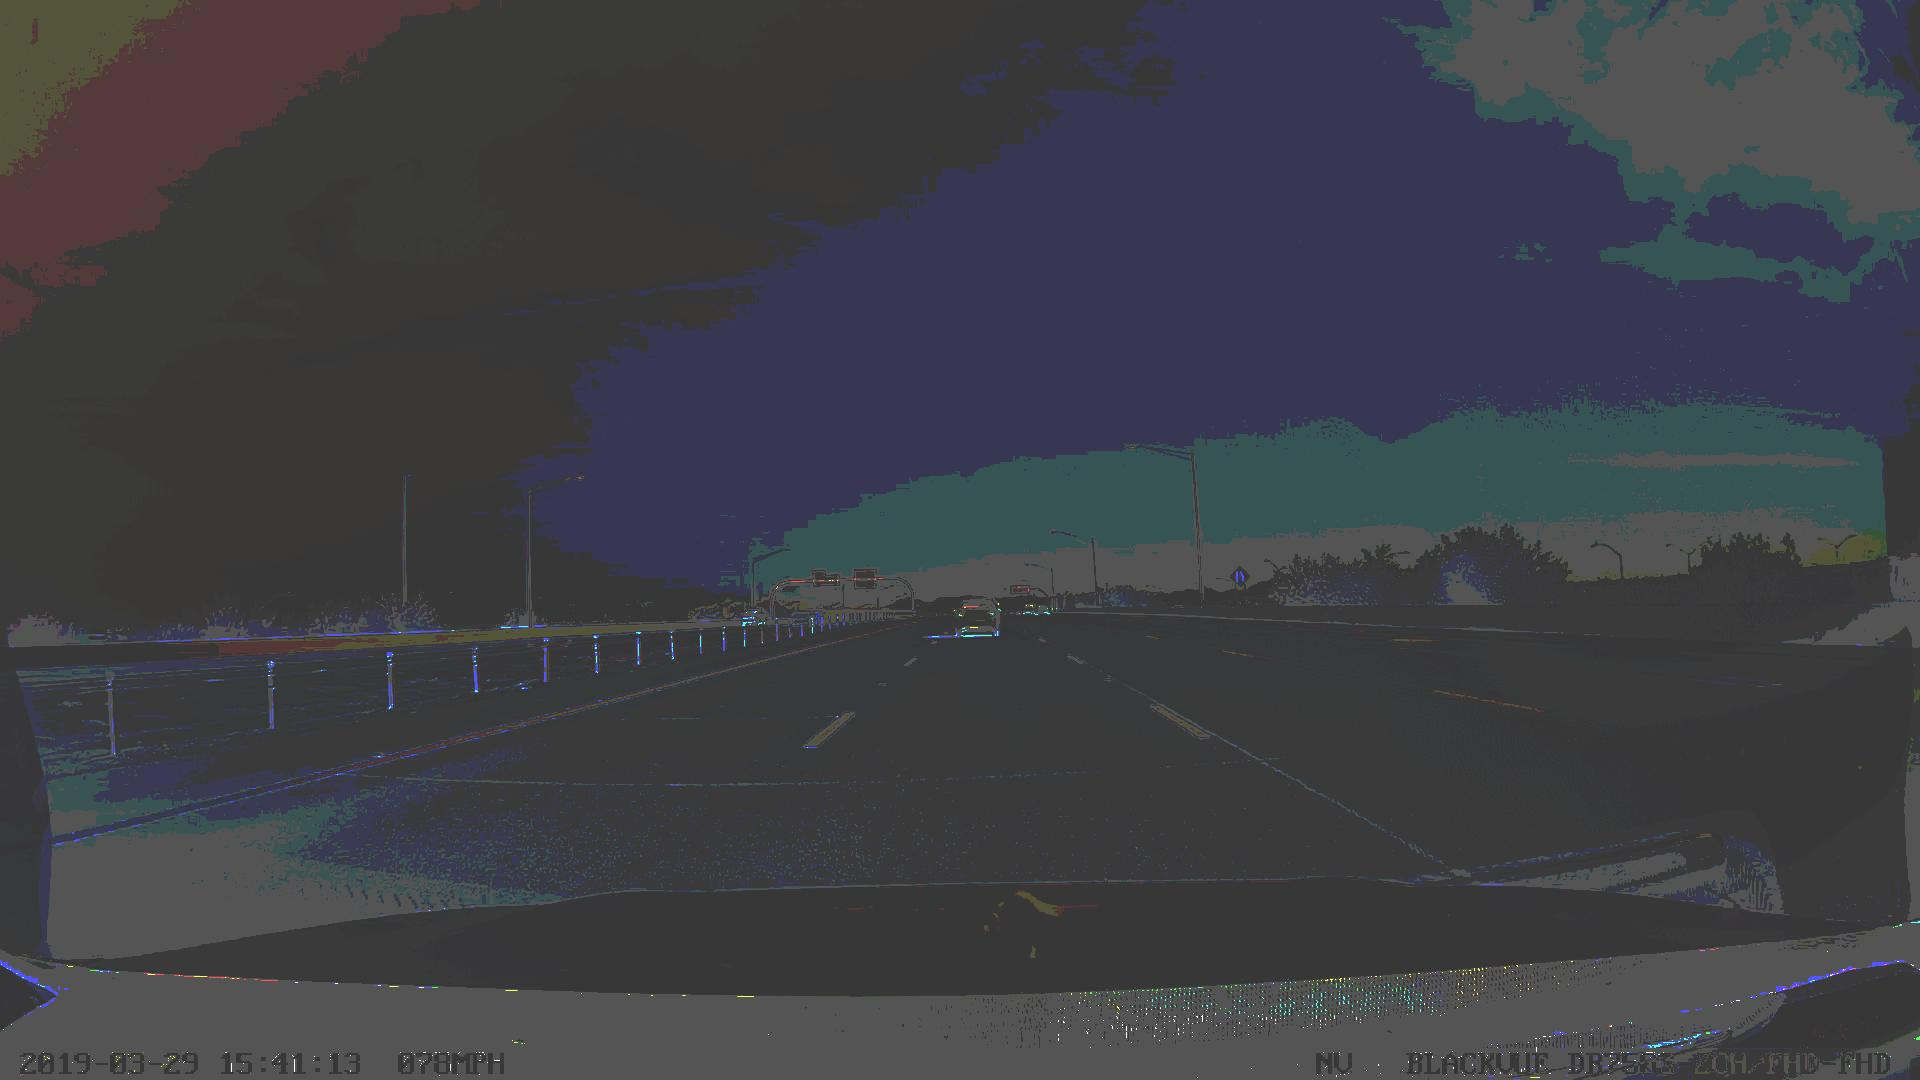

In [113]:
image = image_road

BLUR_RATE = 33
ALPHA = BLUR_RATE
BETA = 5

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blured = cv2.medianBlur(gray,BLUR_RATE)
edges = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, ALPHA, BETA)
k_image = k_threshold(image_road,4)
cartoon = cv2.bitwise_and(k_image, k_image, mask=edges)
showarray(edges)
showarray(k_image)
showarray(cartoon)




# Smaller Color Map

In [21]:
def reduce_to_k_colors(image, k=8):
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    showarray(gray)
    gray = cv2.normalize(gray, 0,255,norm_type=cv2.NORM_MINMAX )
    showarray(gray)
    
    hist  = cv2.calcHist([gray], [0], None, [k], [0, 256])
    print(hist)
    
    hist,bins = np.histogram(image.ravel(),k,[0,256])
    print(hist, bins)
    
    backproj = cv2.calcBackProject([gray], [0], hist, [0,256], scale=1)
    print(backproj)
    

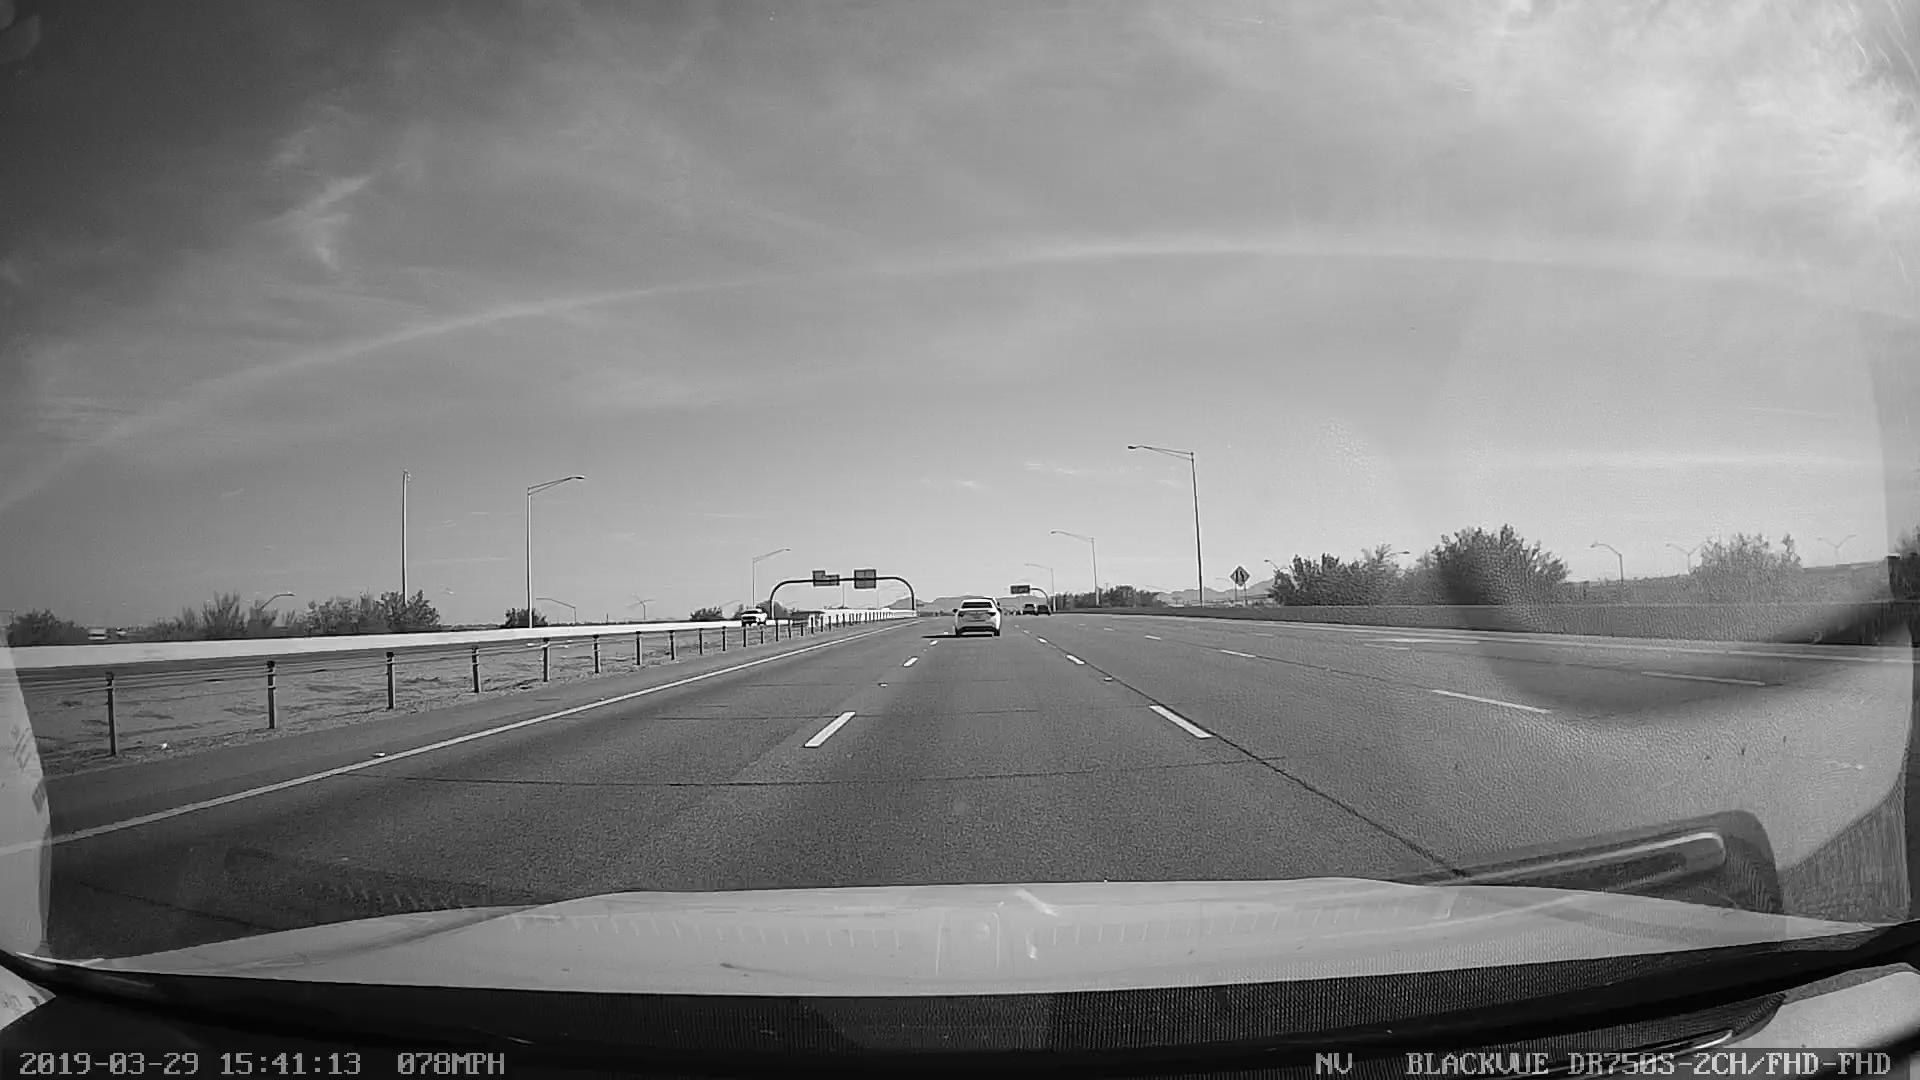

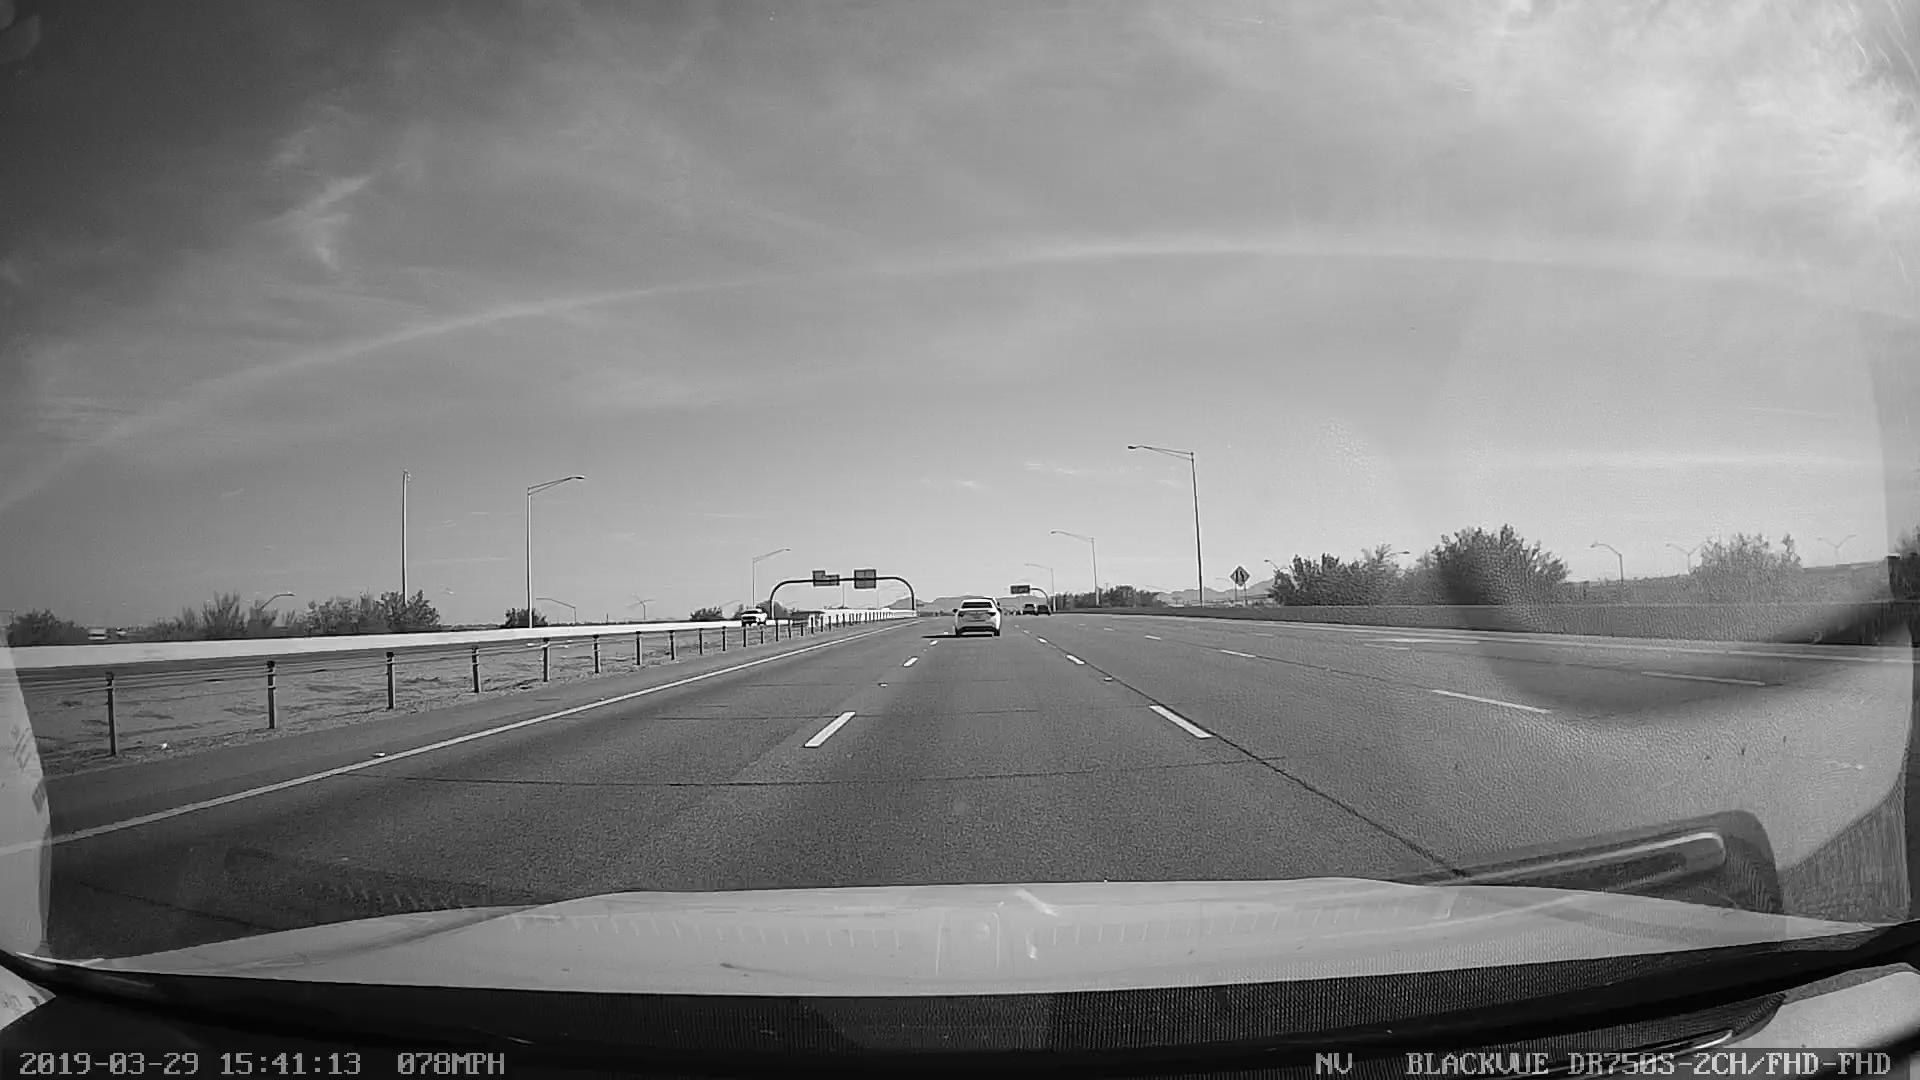

[[138489.]
 [125566.]
 [246428.]
 [384870.]
 [466342.]
 [487368.]
 [220801.]
 [  3736.]]
[ 433113  418618  711842 1120535 1347298 1157631  942296   89467] [  0.  32.  64.  96. 128. 160. 192. 224. 256.]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
reduce_to_k_colors(image_road)


# Threshold

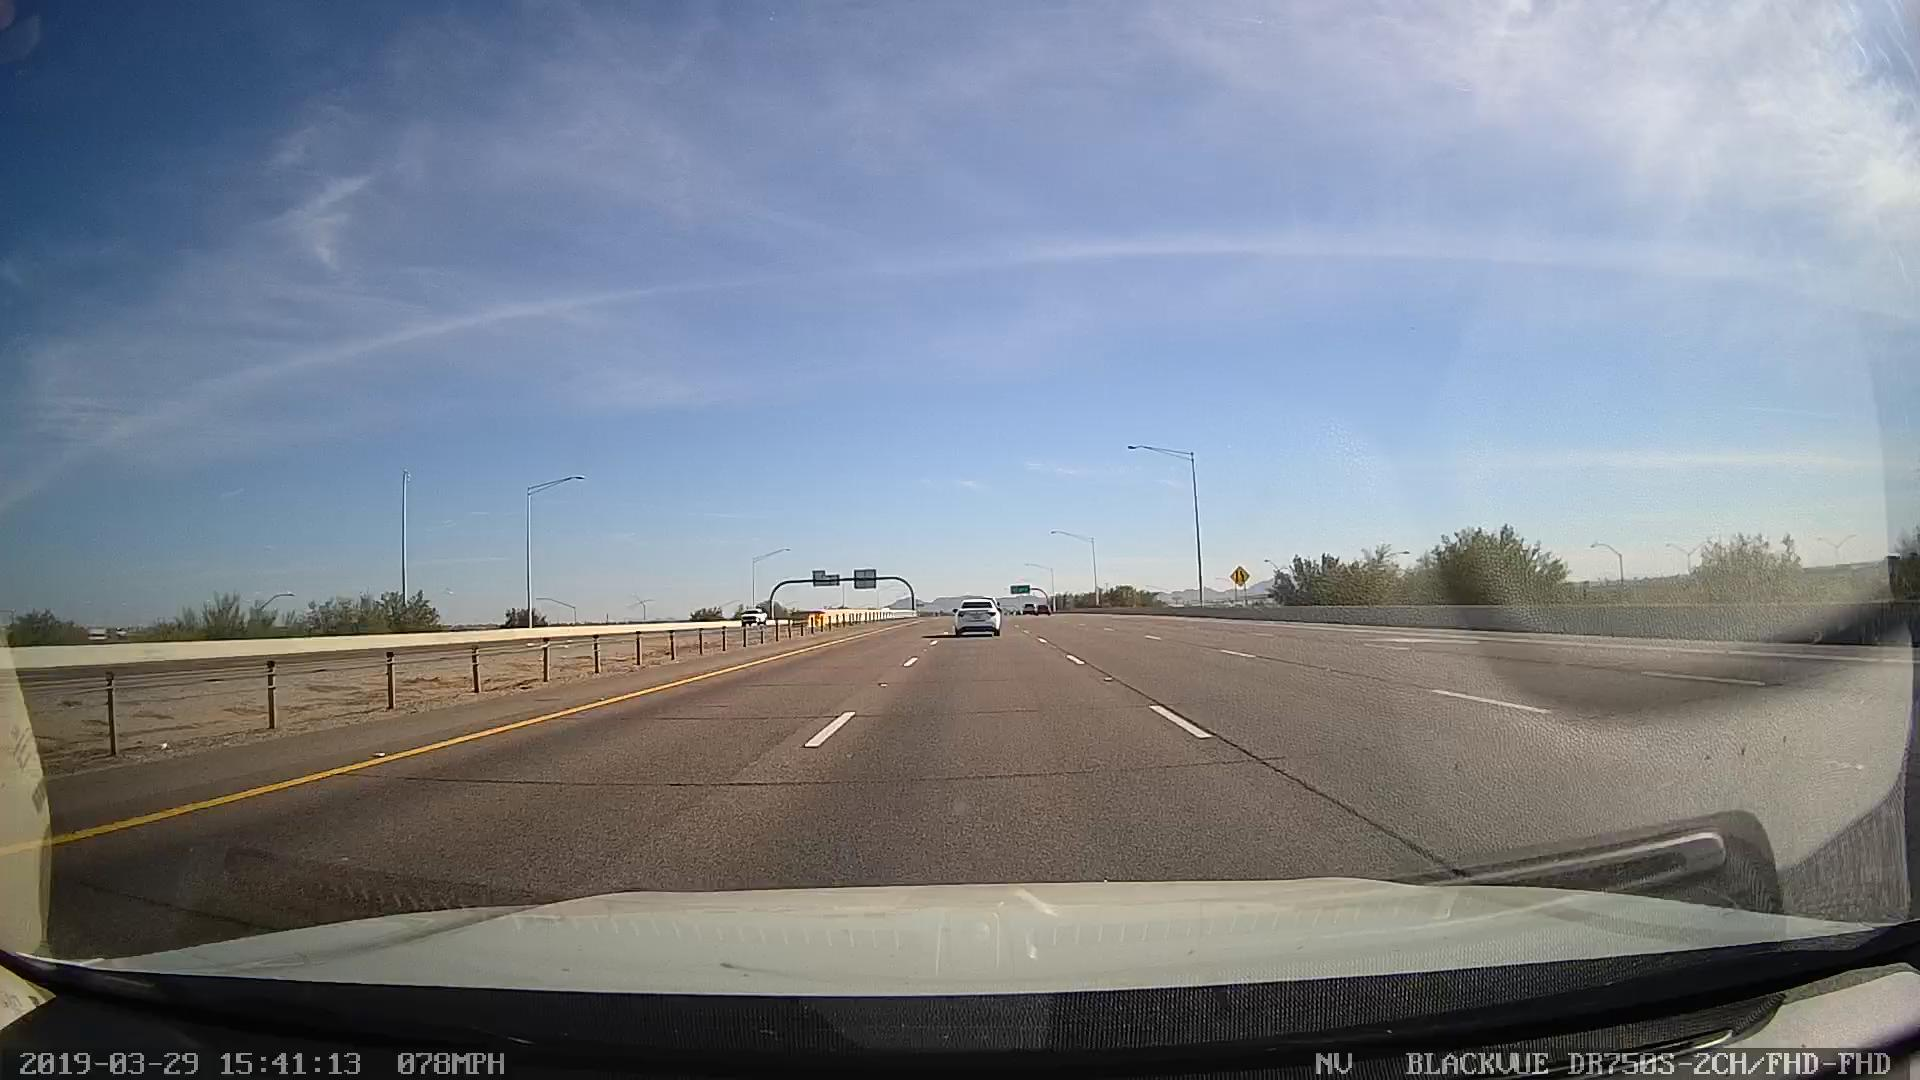

In [111]:
image = image_road
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray,5)
_,th2 = cv2.threshold(gray,124, 255,cv2.THRESH_TOZERO)
showarray(th2)
showarray(image_road)

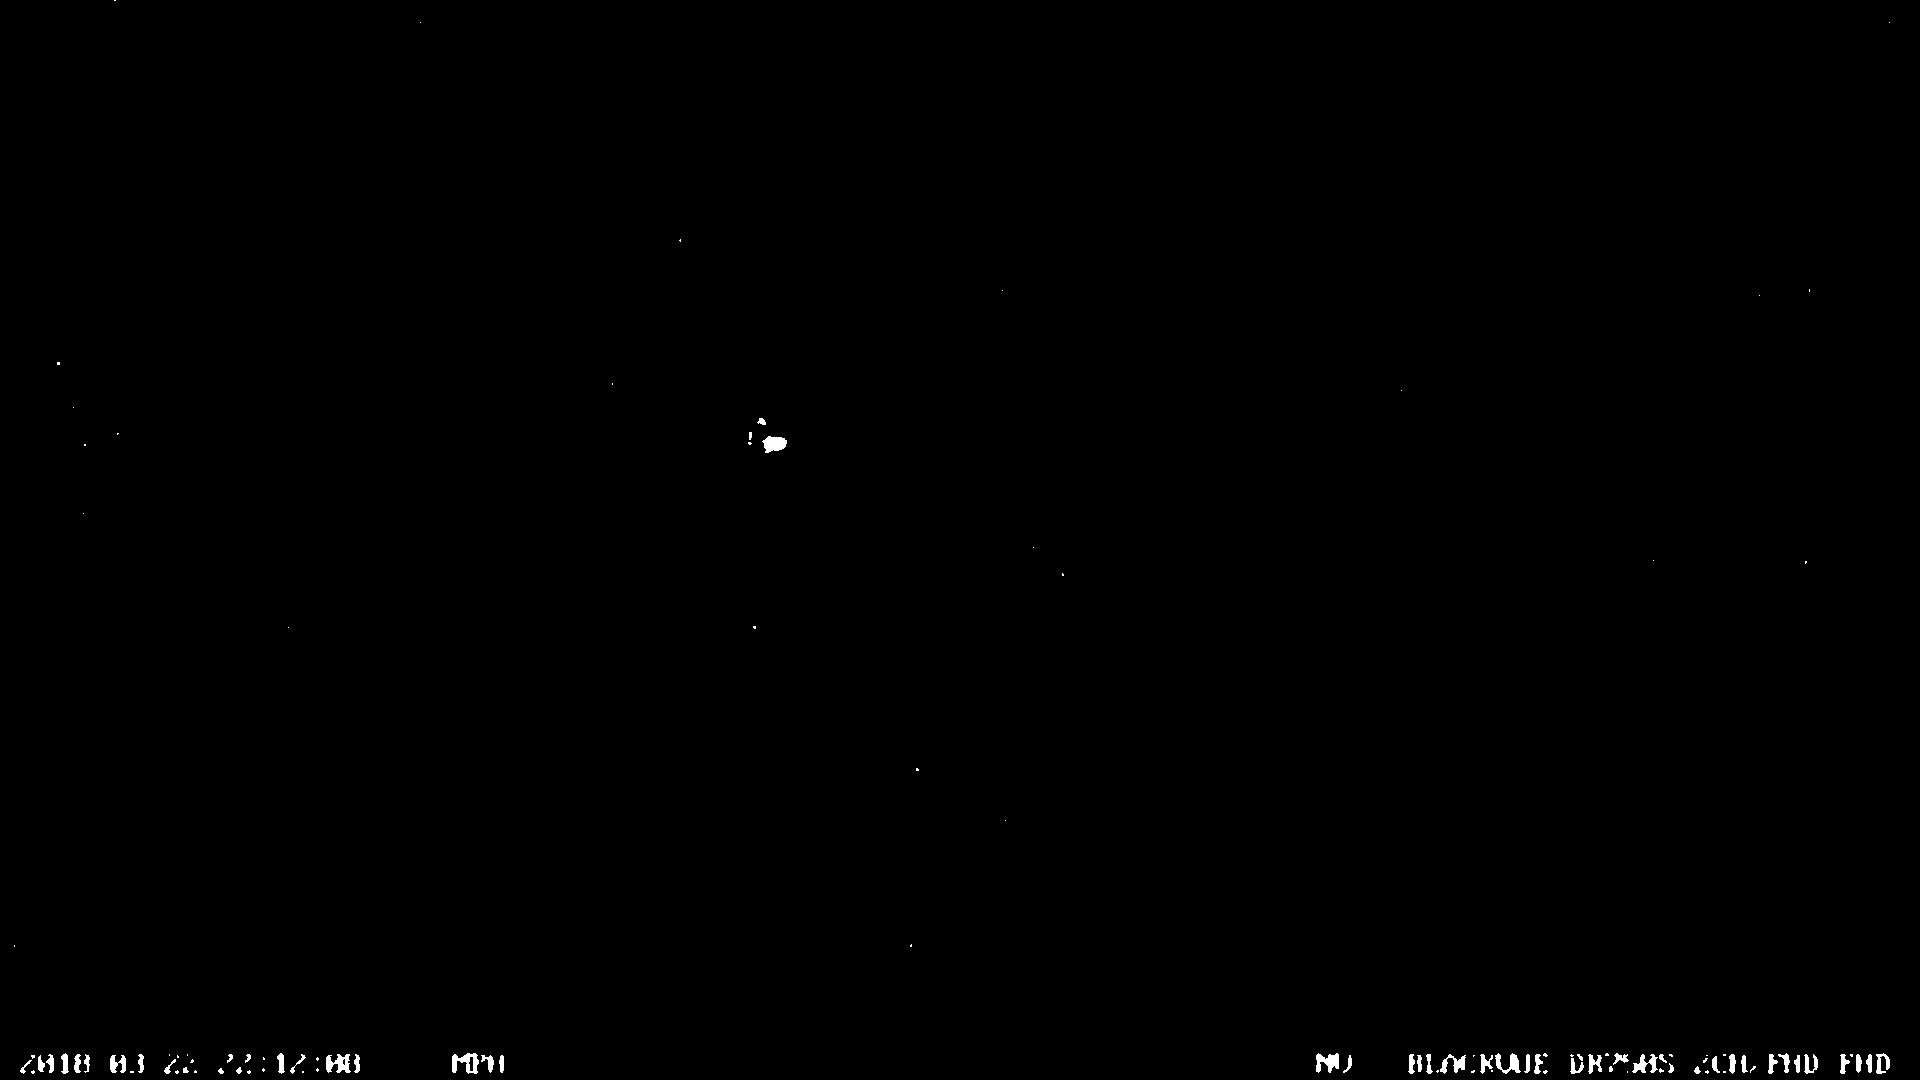

In [123]:
def binary_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    _,th2 = cv2.threshold(gray,124, 255,cv2.THRESH_BINARY)
    # th2 = cv2.bitwise_not(th2)
    return th2
    
showarray(binary_threshold(image_road))
showarray(binary_threshold(image_static))

In [130]:
def split_padded(a,n):
    padding = (-len(a))%n
    return np.split(np.concatenate((a,np.zeros(padding)+255)),n)


def k_threshold(image, k=8):
    print(k)
    MAX = 256
  
    # Create Bins
    x = np.arange(MAX)
    bins = np.amin(split_padded(x, k), axis=1)
    
    # Color Map
    colors = np.amin(split_padded(x, k-1), axis=1)
    colors = np.append(colors, MAX-1)
    print(colors)
    
    # Map pixel values to bins
    inds  = np.digitize(image, bins, right=True)
    inds = inds -1
    
    # Use index to apply colors
    final = np.take(colors, inds.flatten())
    final = final.reshape(image.shape)
    final = final.astype(np.uint8)


    return final

def k_threshold_rgb(image, k=8): 
    b,g,r = cv2.split(image)
    
    bb = k_threshold(b,k)
    gg = k_threshold(g,k)
    rr = k_threshold(r,k)
    
    img = cv2.merge((bb,gg,rr))

    return img

def k_threshold_c(image, c='r', k=8): 
    b,g,r = cv2.split(image)
    
    print(c)
    if c == 'r':
        img = k_threshold(b,k)
    if c == 'g':
        img = k_threshold(g,k)
    if c == 'b':
        img = k_threshold(r,k)
    
#     img = cv2.merge((bb,gg,rr))

    img =  cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img


def k_threshold_grayscale(image, k=8):
    
    # See https://stackoverflow.com/questions/32678992/reduce-image-to-n-colors-in-opencv-python
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    
    return k_threshold(gray, k)
    

# showarray(binary_threshold(image_static))

2
[  0. 255.]


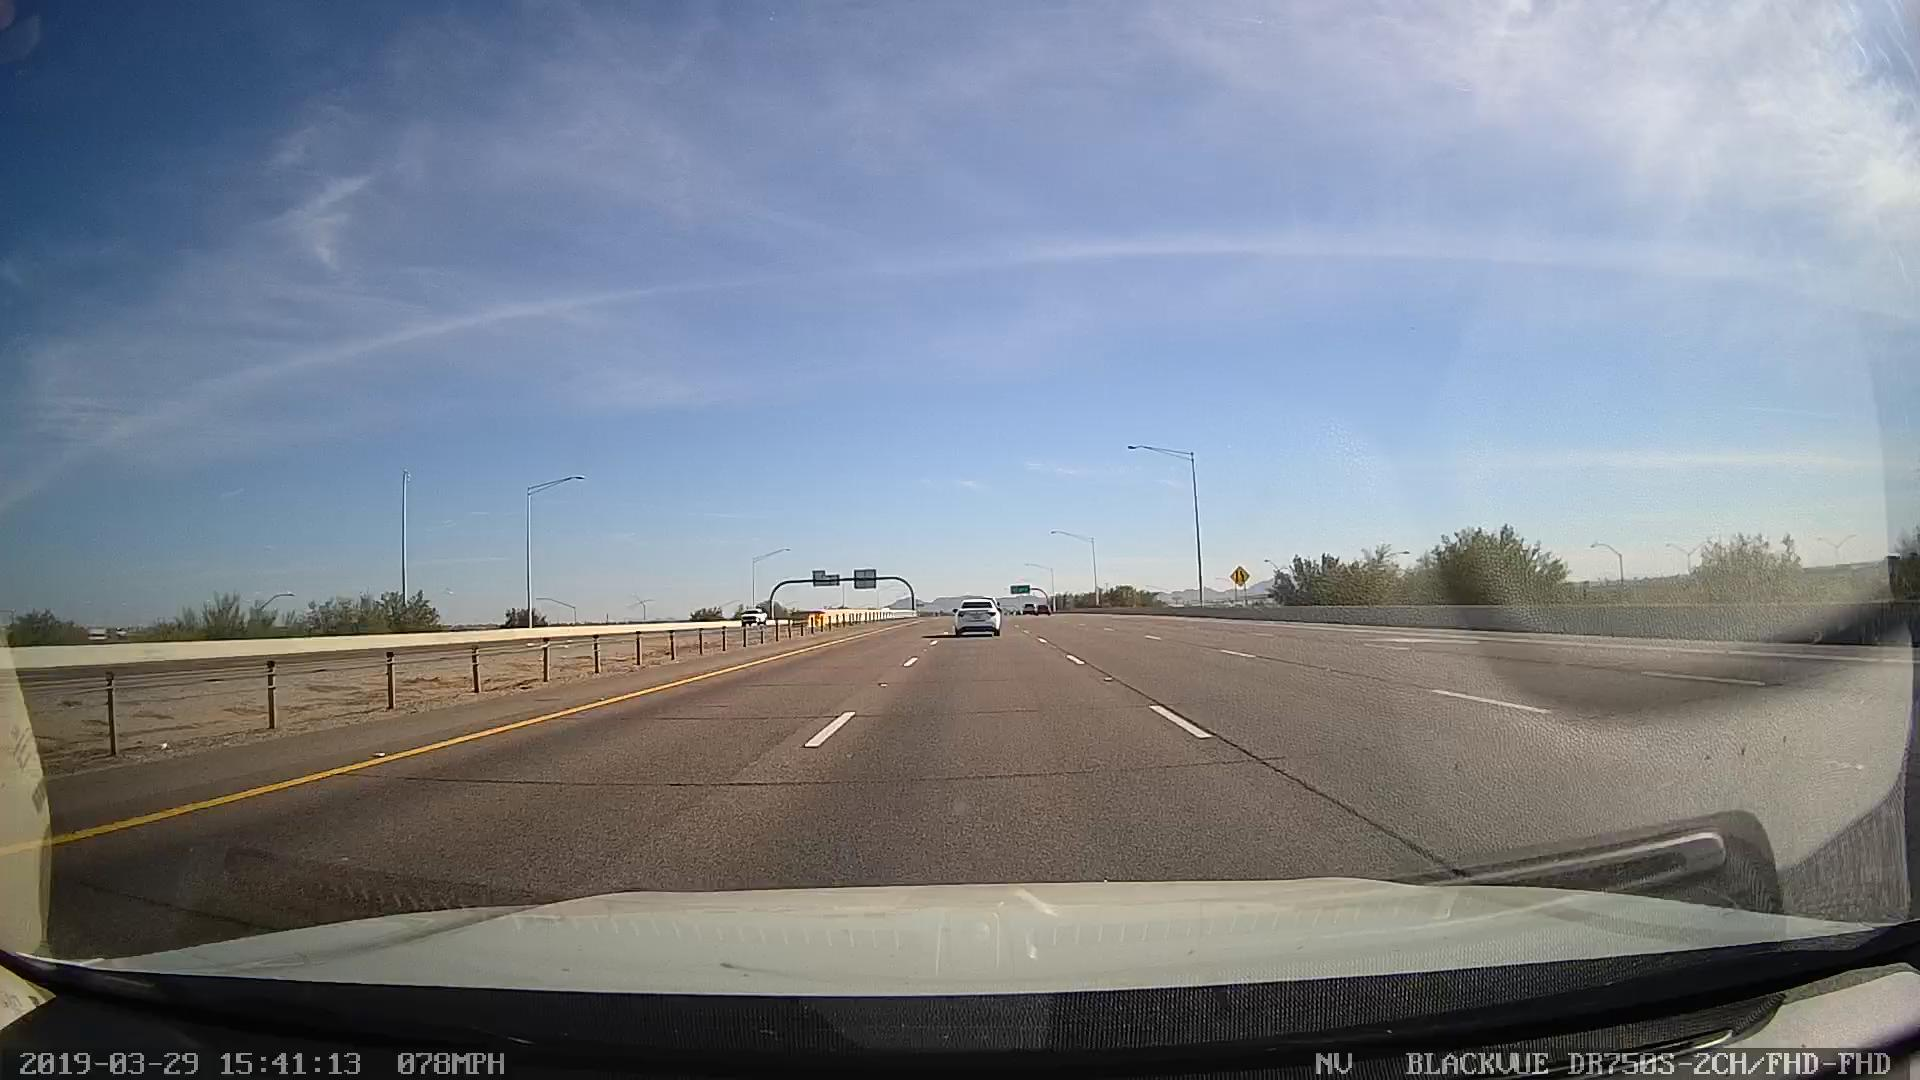

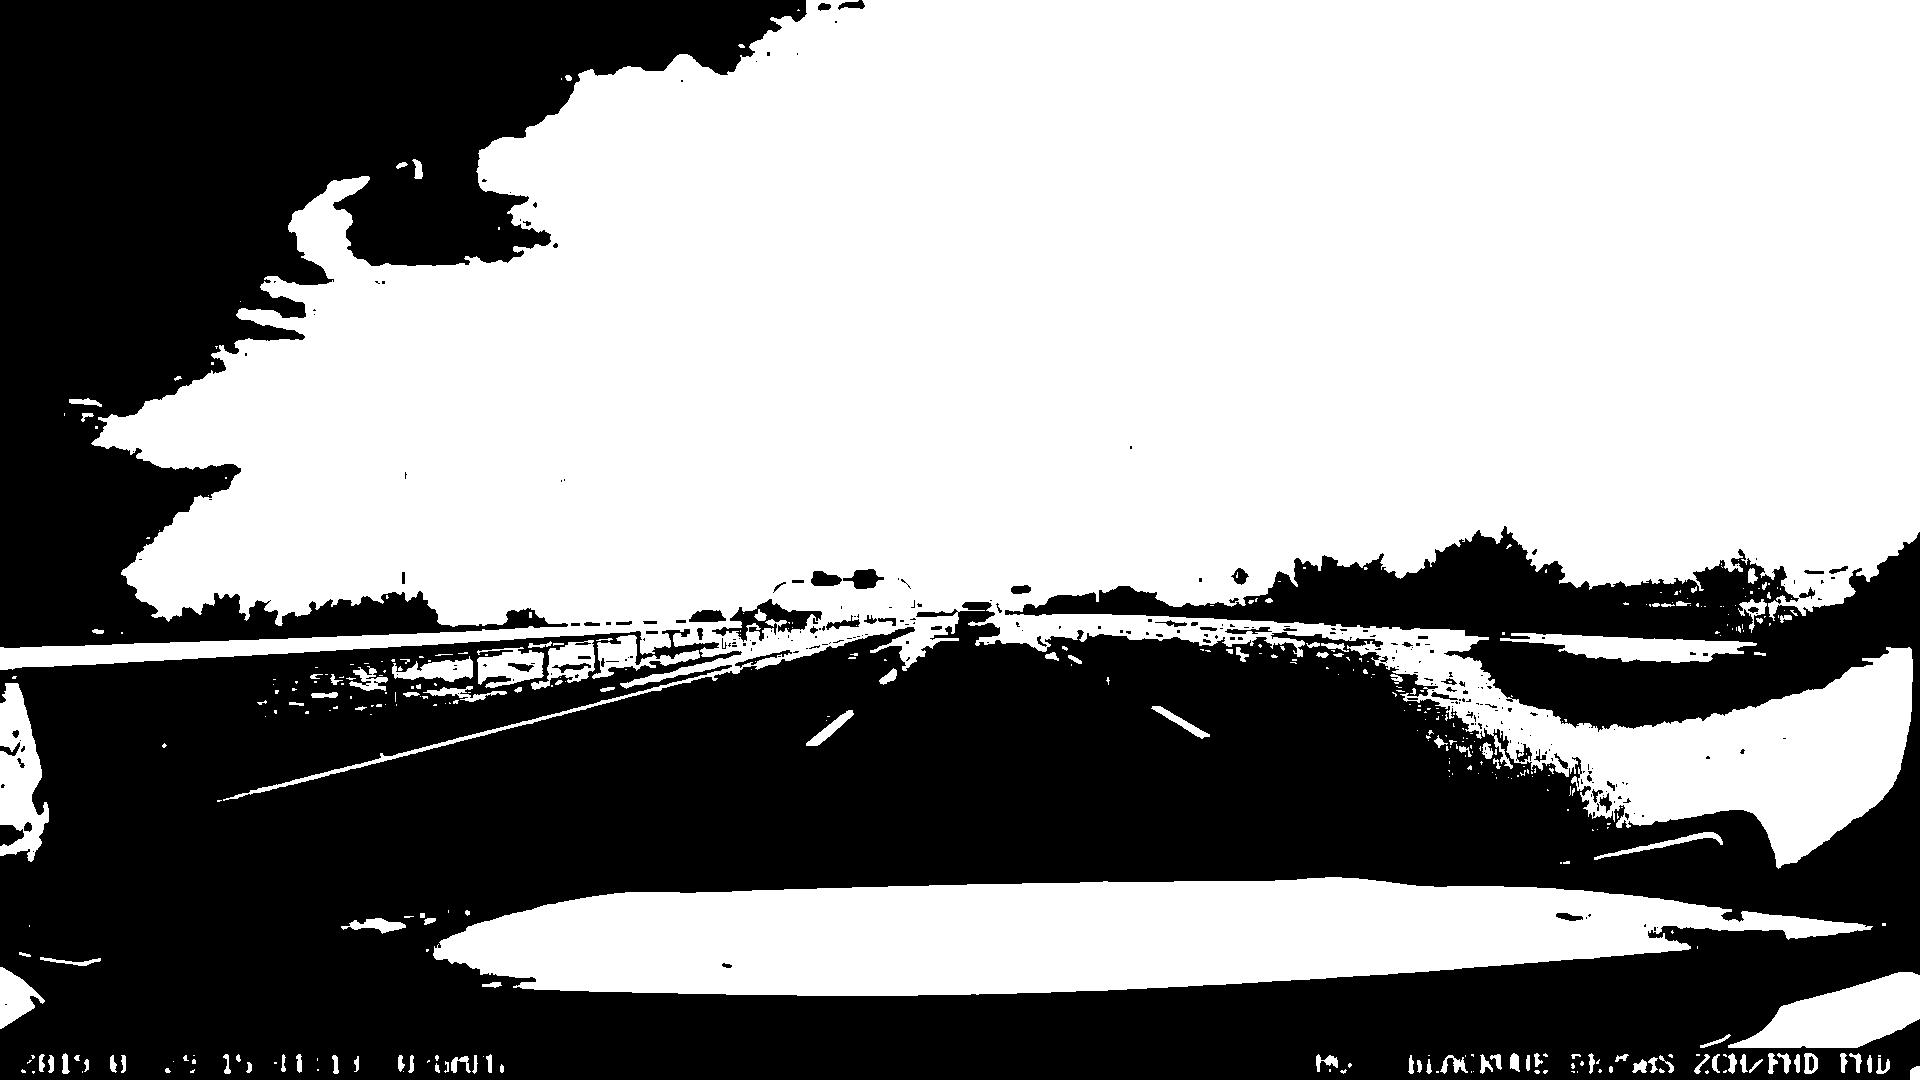

In [131]:
k_image = k_threshold_grayscale(image_road,2)
showarray(image_road)
showarray(k_image)

2
[  0. 255.]
2
[  0. 255.]
2
[  0. 255.]


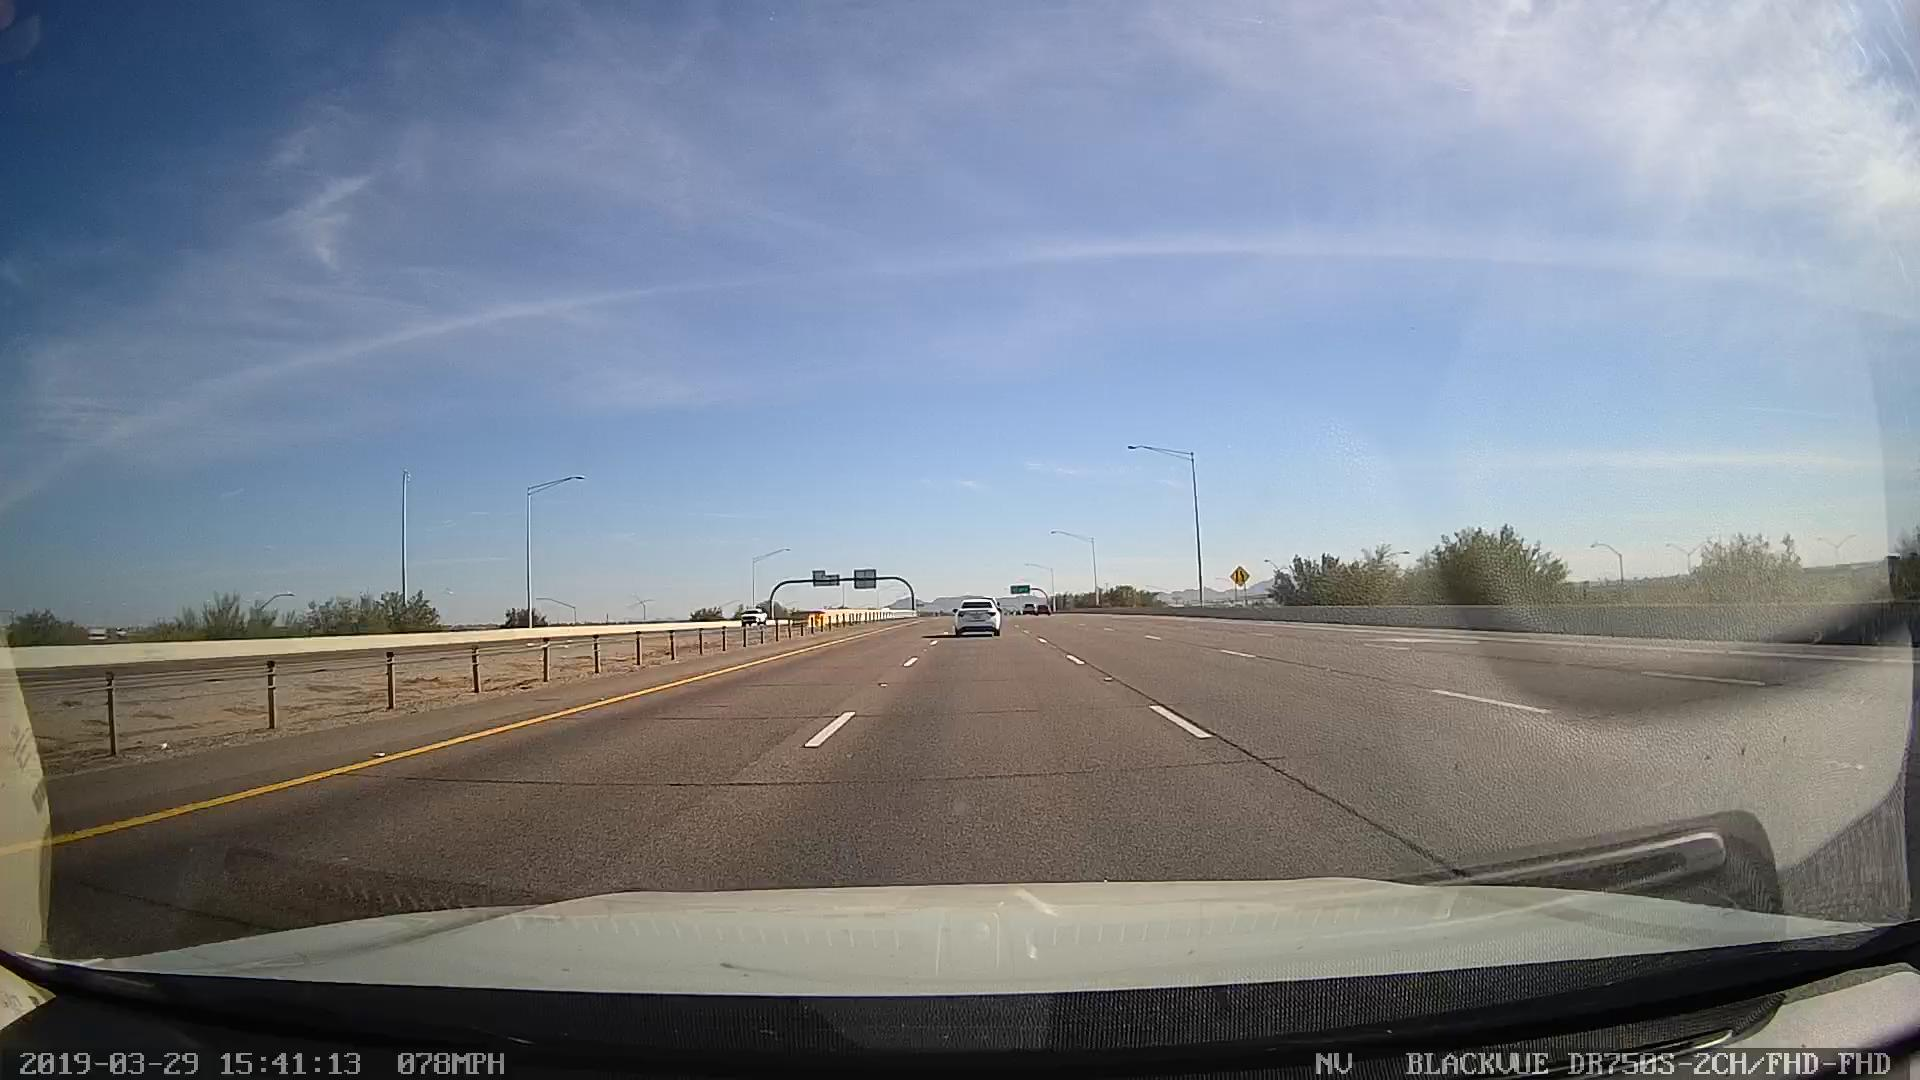

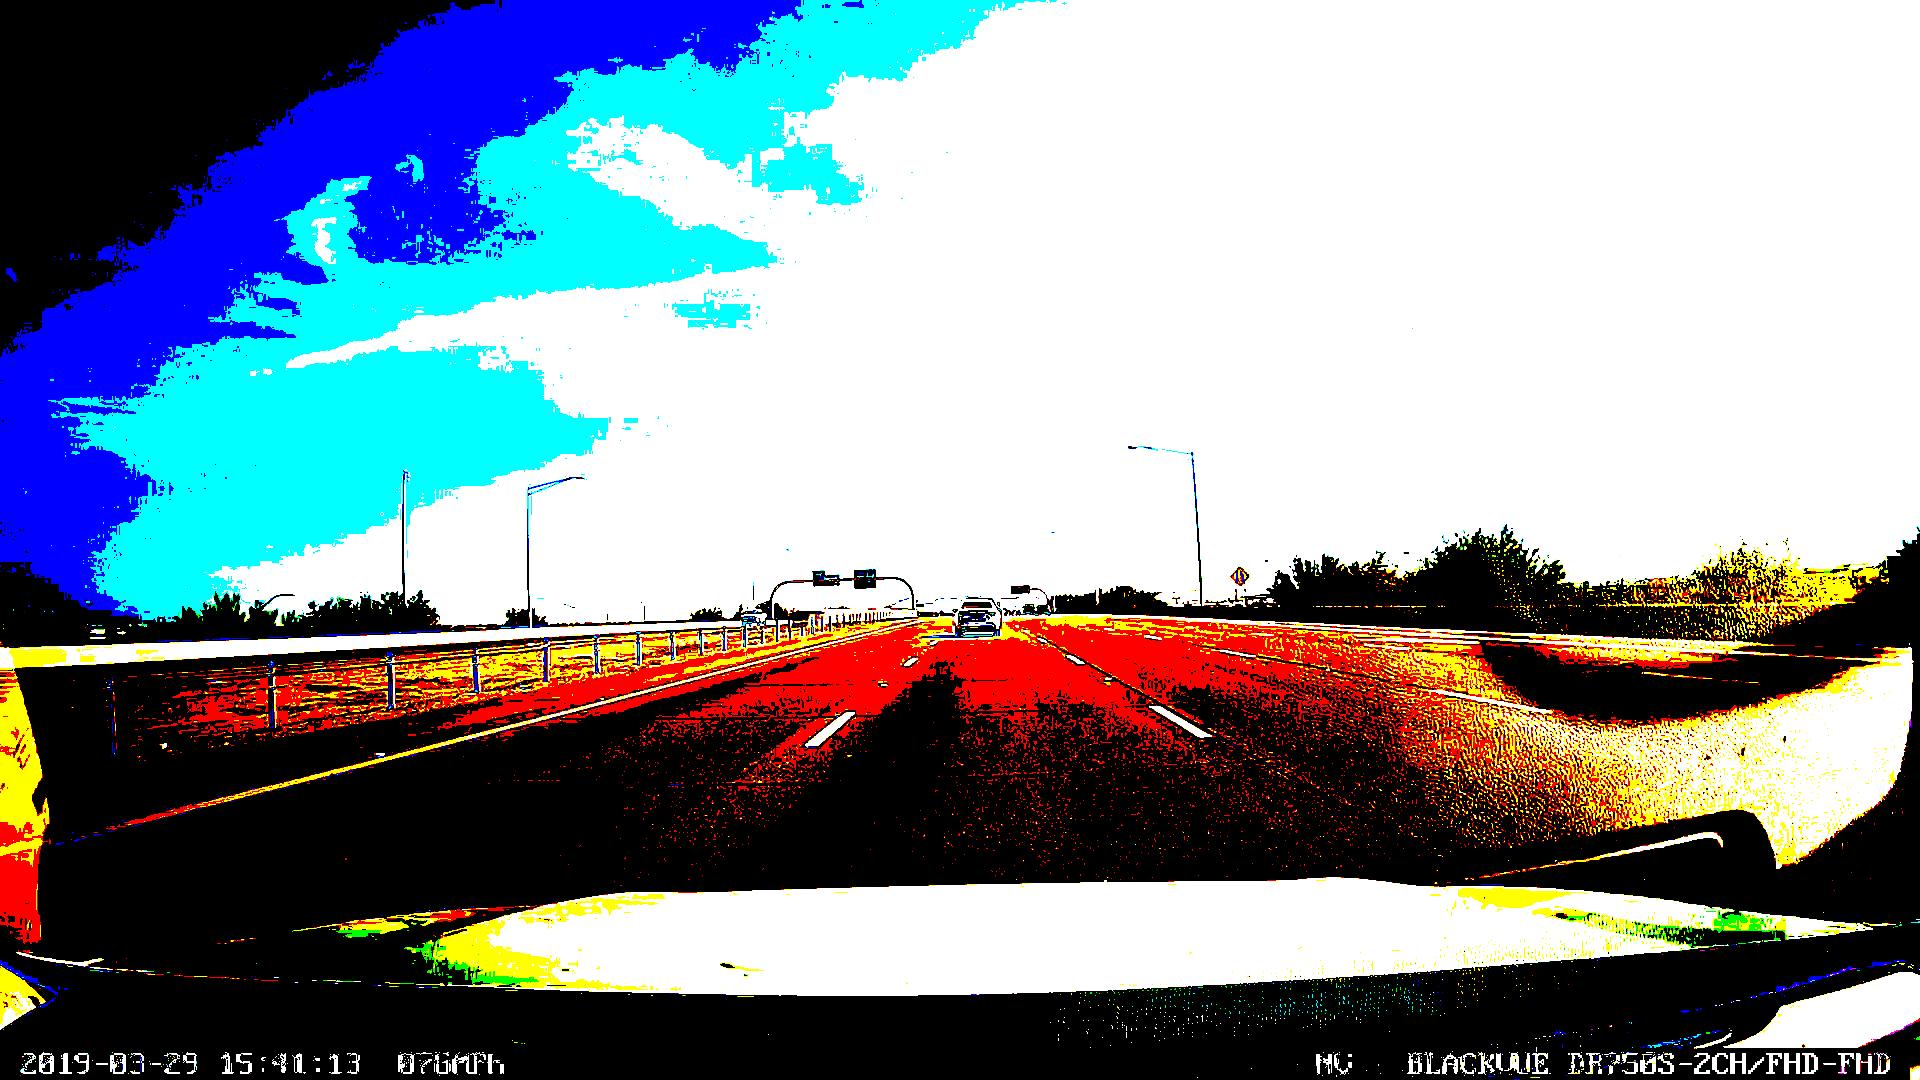

In [138]:
k_image = k_threshold_rgb(image_road,2)
showarray(image_road)
showarray(k_image)

g
2
[  0. 255.]


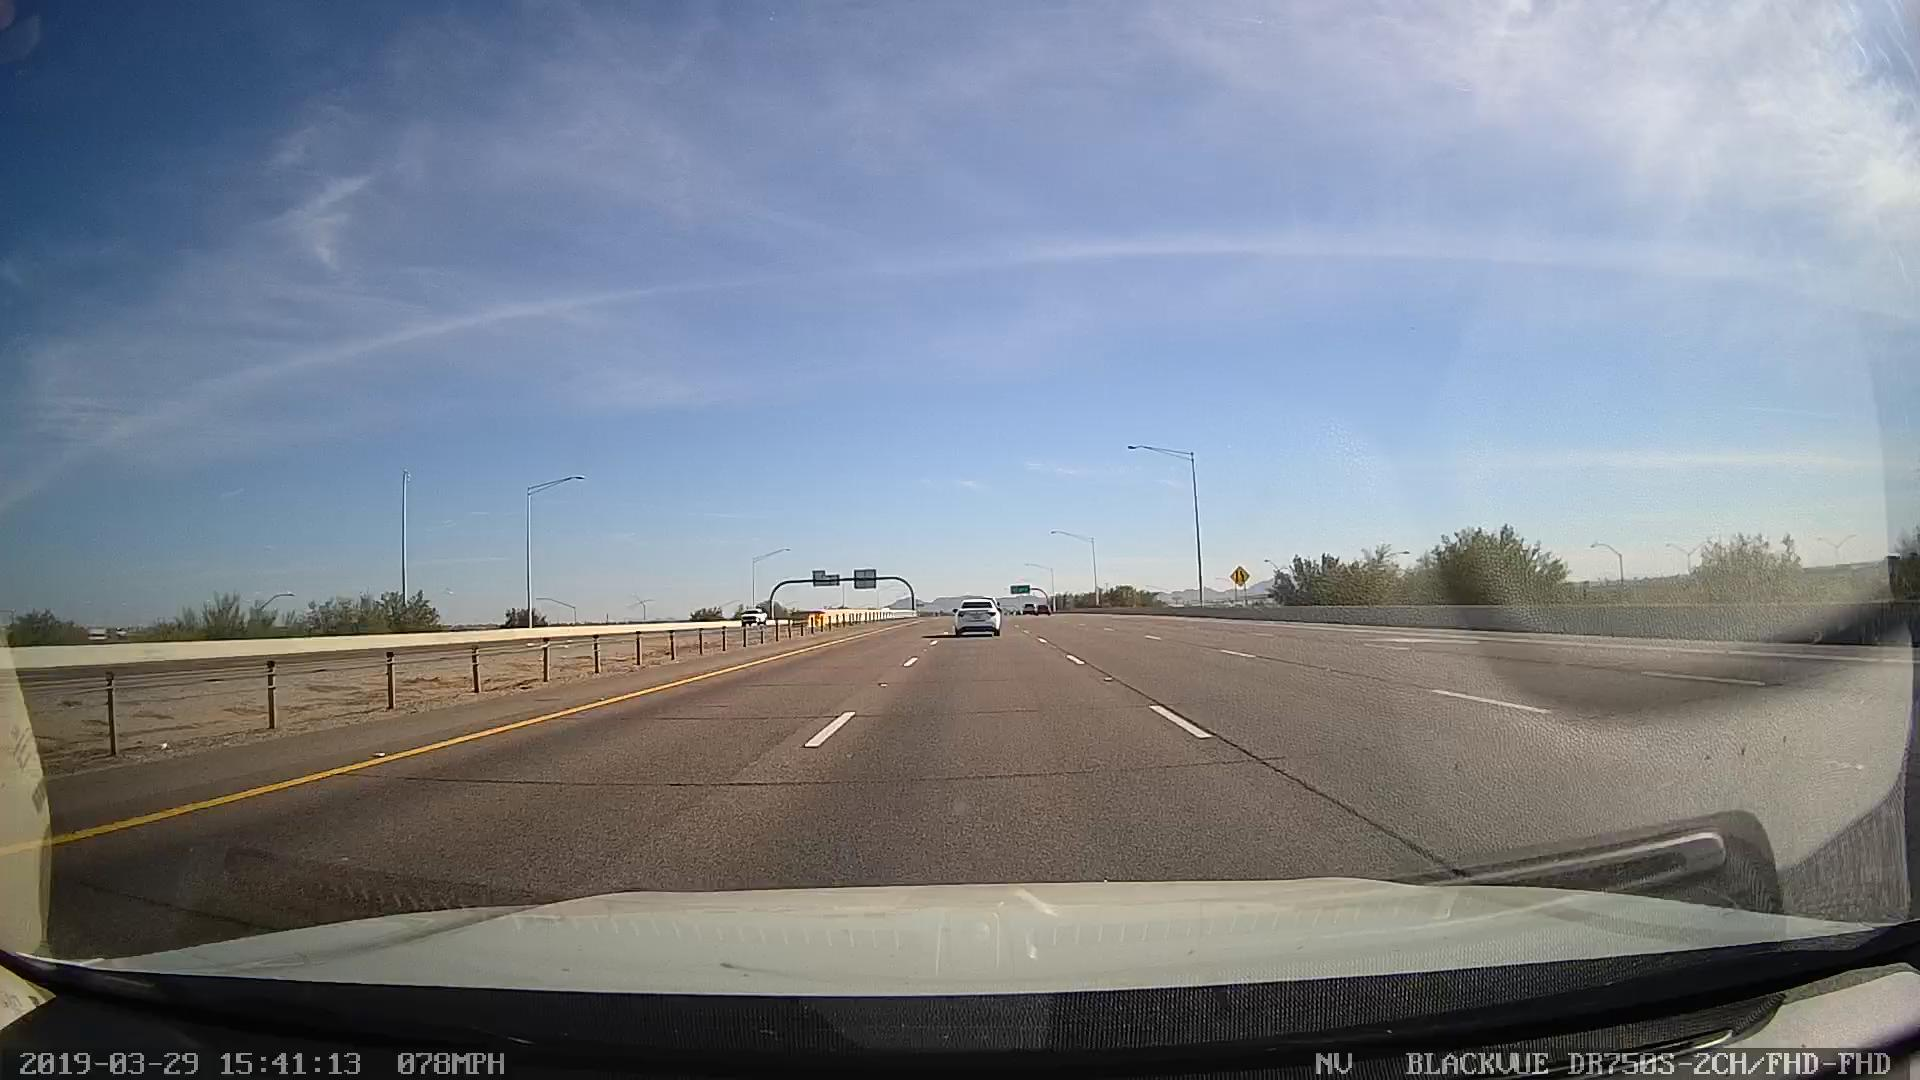

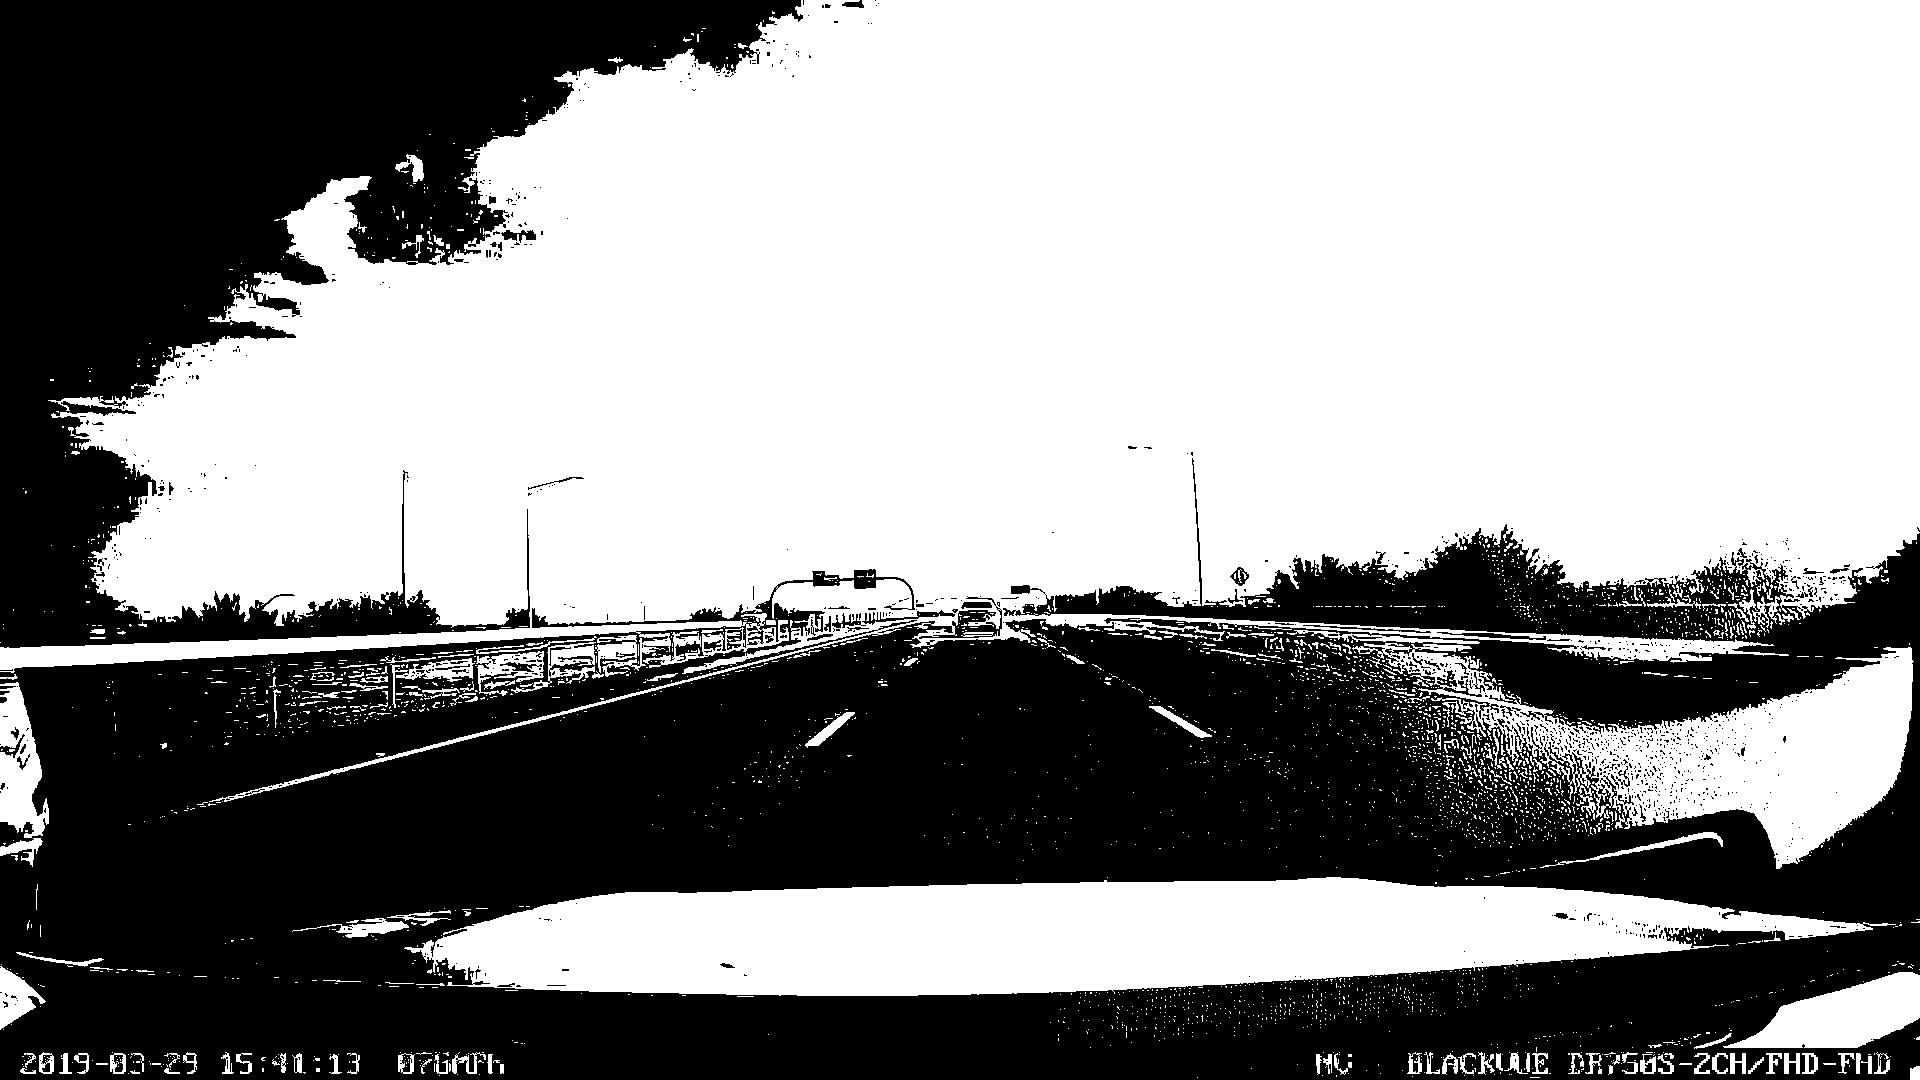

In [142]:
k_image = k_threshold_c(image_road,'g',2)
showarray(image_road)
showarray(k_image)

In [99]:
c = 'r'

In [100]:
c == 'r'

True